<a href="https://colab.research.google.com/github/kmeng01/rome/blob/main/notebooks/causal_trace.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

In [1]:
# %%bash
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
# cd /content && rm -rf /content/rome
# git clone https://github.com/kmeng01/rome rome > install.log 2>&1
# pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
# pip install --upgrade google-cloud-storage >> install.log 2>&1

In [2]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

## Causal Tracing

A demonstration of the double-intervention causal tracing method.

The strategy used by causal tracing is to understand important
states within a transfomer by doing two interventions simultaneously:

1. Corrupt a subset of the input.  In our paper, we corrupt the subject tokens
   to frustrate the ability of the transformer to accurately complete factual
   prompts about the subject.
2. Restore a subset of the internal hidden states.  In our paper, we scan
   hidden states at all layers and all tokens, searching for individual states
   that carry the necessary information for the transformer to recover its
   capability to complete the factual prompt.

The traces of decisive states can be shown on a heatmap.  This notebook
demonstrates the code for conducting causal traces and creating these heatmaps.

In [3]:
%load_ext autoreload
%autoreload 2

The `experiments.causal_trace` module contains a set of functions for running causal traces.

In this notebook, we reproduce, demonstrate and discuss the interesting functions.

We begin by importing several utility functions that deal with tokens and transformer models.

In [4]:
import os, sys, re, json
import string
import torch
import numpy as np
import copy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset

In [5]:
torch.set_grad_enabled(False)

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Now we load a model and tokenizer, and show that it can complete a couple factual statements correctly.

In [5]:
# model_name = "gpt2-xl"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
# mt = ModelAndTokenizer(
#     model_name,
#     low_cpu_mem_usage=IS_COLAB,
#     torch_dtype=(torch.float16 if "20b" in model_name else None),
# )

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

In [ ]:
# mt.model

In [6]:
# predict_token(
#     mt,
#     ["Megan Rapinoe plays the sport of", "The Space Needle is in the city of"],
#     return_p=True,
# )

([' soccer', ' Seattle'], tensor([0.7675, 0.9552], device='cuda:0'))

To obfuscate the subject during Causal Tracing, we use noise sampled from a zero-centered spherical Gaussian, whose stddev is 3 times the $\sigma$ stddev the model's embeddings. Let's compute that value.

In [7]:
# knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
# noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
# print(f"Using noise level {noise_level}")

data/known_1000.json does not exist. Downloading from https://rome.baulab.info/data/dsets/known_1000.json


  0%|          | 0.00/335k [00:00<?, ?B/s]

Loaded dataset with 1209 elements
Using noise level 0.13462981581687927


## Tracing a single location

The core intervention in causal tracing is captured in this function:

`trace_with_patch` a single causal trace.

It enables running a batch of inferences with two interventions.

  1. Random noise can be added to corrupt the inputs of some of the batch.
  2. At any point, clean non-noised state can be copied over from an
     uncorrupted batch member to other batch members.
  
The convention used by this function is that the zeroth element of the
batch is the uncorrupted run, and the subsequent elements of the batch
are the corrupted runs.  The argument tokens_to_mix specifies an
be corrupted by adding Gaussian noise to the embedding for the batch
inputs other than the first element in the batch.  Alternately,
subsequent runs could be corrupted by simply providing different
input tokens via the passed input batch.

To ensure that corrupted behavior is representative, in practice, we
will actually run several (ten) corrupted runs in the same batch,
each with its own sample of noise.

Then when running, a specified set of hidden states will be uncorrupted
by restoring their values to the same vector that they had in the
zeroth uncorrupted run.  This set of hidden states is listed in
states_to_patch, by listing [(token_index, layername), ...] pairs.
To trace the effect of just a single state, this can be just a single
token/layer pair.  To trace the effect of restoring a set of states,
any number of token indices and layers can be listed.

Note that this function is also in experiments.causal_trace; the code
is shown here to show the logic.

In [8]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Scanning all locations

A causal flow heatmap is created by repeating `trace_with_patch` at every individual hidden state, and measuring the impact of restoring state at each location.

The `calculate_hidden_flow` function does this loop.  It handles both the case of restoring a single hidden state, and also restoring MLP or attention states.  Because MLP and attention make small residual contributions, to observe a causal effect in those cases, we need to restore several layers of contributions at once, which is done by `trace_important_window`.

In [9]:
def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            r = trace_with_patch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            r = trace_with_patch(
                model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

## Plotting the results

The `plot_trace_heatmap` function draws the data on a heatmap.  That function is not shown here; it is in `experiments.causal_trace`.


In [10]:
def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)


def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None):
    for kind in [None, "mlp", "attn"]:
        plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind
        )

The following prompt can be changed to any factual statement to trace.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


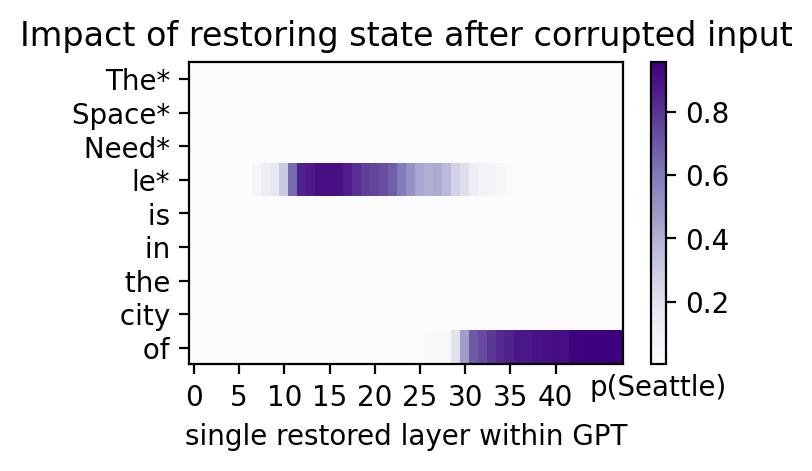

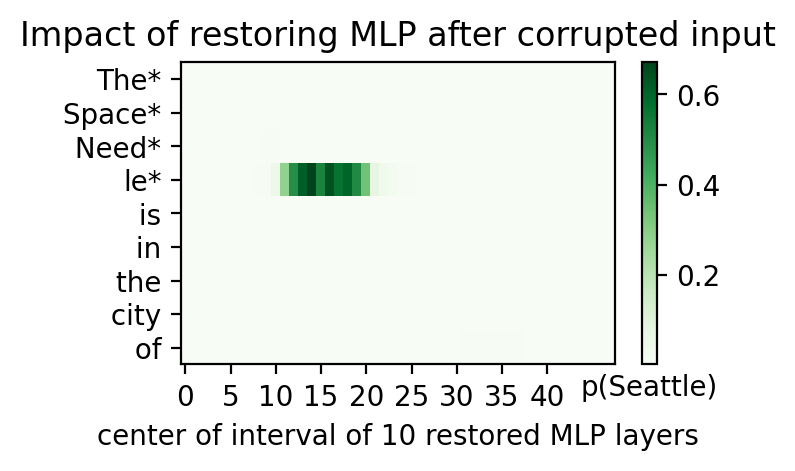

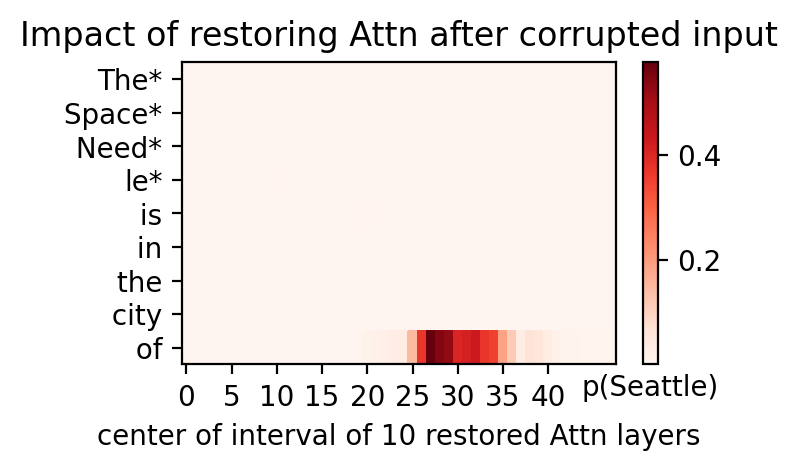

In [11]:
plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level)

Here we trace a few more factual statements from a file of test cases.

In [12]:
knowns[:5]

[{'known_id': 0,
  'subject': 'Vinson Massif',
  'attribute': 'Antarctica',
  'template': '{} is located in the continent',
  'prediction': ' of Antarctica. It is the largest of the three',
  'prompt': 'Vinson Massif is located in the continent of',
  'relation_id': 'P30'},
 {'known_id': 1,
  'subject': 'Beats Music',
  'attribute': 'Apple',
  'template': '{} is owned by',
  'prediction': ' Apple, which is also the owner of Beats Electronics',
  'prompt': 'Beats Music is owned by',
  'relation_id': 'P127'},
 {'known_id': 2,
  'subject': 'Audible.com',
  'attribute': 'Amazon',
  'template': '{} is owned by',
  'prediction': ' Amazon.com, Inc. or its affiliates.',
  'prompt': 'Audible.com is owned by',
  'relation_id': 'P127'},
 {'known_id': 3,
  'subject': 'The Big Bang Theory',
  'attribute': 'CBS',
  'template': '{} premieres on',
  'prediction': ' CBS on September 22.<|endoftext|>',
  'prompt': 'The Big Bang Theory premieres on',
  'relation_id': 'P449'},
 {'known_id': 4,
  'subject'

In [ ]:
for knowledge in knowns[:5]:
    plot_all_flow(mt, knowledge["prompt"], knowledge["subject"], noise=noise_level)

## Checking T5

In [44]:
from transformers import AutoModel

from experiments import causal_trace_t5 as ctt5

In [15]:
t5_name = "t5-base"

t5_model = AutoModel.from_pretrained(t5_name)

In [ ]:
t5_model

In [ ]:
[n for n, m in mt.model.named_modules()]

In [ ]:
[n for n, m in t5_model.named_modules()]

In [26]:
t5_model.shared == t5_model.encoder.embed_tokens == t5_model.decoder.embed_tokens

True

In [122]:
model_name = "t5-base"
mt = ctt5.ModelAndTokenizer_T5(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [123]:
res = ctt5.predict_token_t5(
    mt,
    enc_sentences=["translate English to German: My name is Wolfgang and I live in Berlin."],
    dec_prompts=["Mein Name ist"],
    return_p=True,
)

In [124]:
res

(['Wolfgang'], tensor([0.9922], device='cuda:0'))

In [155]:
inp = ctt5.make_inputs_t5(
    mt.tokenizer,
    enc_sentences=["Translate to German: My name is Wolfgang and I live in Berlin"],
    dec_prompts=["Mein Name ist Wolfgang"],
    device="cuda:0",
)

In [156]:
inp

{'input_ids': tensor([[30355,    15,    12,  2968,    10,   499,   564,    19, 26513,    11,
             27,   619,    16,  4308,     1]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 'decoder_input_ids': tensor([[    0, 16232,  5570,   229, 26513]], device='cuda:0'),
 'decoder_attention_mask': tensor([[1, 1, 1, 1, 1]], device='cuda:0')}

In [157]:
mt.tokenizer.decode(inp['decoder_input_ids'][0])

'<pad> Mein Name ist Wolfgang'

In [158]:
out = mt.model(**inp)

In [159]:
out["logits"].size()

torch.Size([1, 5, 32128])

In [160]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32128,)

In [161]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(64, -2.0804775),
 (6, -4.0525026),
 (11, -5.717272),
 (5, -5.8535347),
 (3, -7.126668)]

In [162]:
[mt.tokenizer.decode([p[0]]) for p in top_5]

['und', ',', 'and', '.', '']

### T5 analysis

In [163]:
result = ctt5.calculate_hidden_flow_t5(
    mt,
    enc_sentence="Translate to German: My name is Wolfgang and I live in Berlin",
    dec_prompt="Mein Name ist Wolfgang",
    subject="and",
)

trace_important_states_t5.encoder:   0%|          | 0/180 [00:00<?, ?it/s]

trace_important_states_t5.decoder:   0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
ctt5.plot_trace_heatmap_t5(result)

In [134]:
# named_modules remove_duplicate
set([k for k,v in mt.model.named_modules(remove_duplicate=False)]) - set([k for k,v in mt.model.named_modules(remove_duplicate=True)])

{'decoder.embed_tokens', 'encoder.embed_tokens'}

In [ ]:
# named_parameters: `remove_duplicate` not available (don't know how to include dup here...)
([k for k,v in mt.model.named_parameters()])

## USKG

In [353]:
from transformers import (
    HfArgumentParser,
    set_seed,
    AutoTokenizer
)

# from uskg.models.unified.prefixtuning import Model
from uskg.models.unified import finetune, prefixtuning
from uskg.utils.configue import Configure
from uskg.utils.training_arguments import WrappedSeq2SeqTrainingArguments
from uskg.seq2seq_construction import spider as s2s_spider
from uskg.third_party.spider.preprocess.get_tables import dump_db_json_schema
from uskg.third_party.spider import evaluation as sp_eval
from tqdm.auto import tqdm

# from nltk.stem.wordnet import WordNetLemmatizer
# import stanza

import matplotlib.pyplot as plt
import sqlite3

from experiments import causal_trace_uskg as ctu

In [313]:
mt_uskg = ctu.ModelAndTokenizer_USKG('t5-large-prefix')

Using tokenizer_uskg: hkunlp/from_all_T5_large_prefix_spider_with_cell_value2
Using tokenizer_fast: t5-large
prefix-tuning sequence length is 10.


In [314]:
list(mt_uskg.task_args.seq2seq)

[('constructor', 'seq2seq_construction.spider'),
 ('schema_serialization_with_db_content', True),
 ('target_with_db_id', False)]

In [315]:
mt_uskg.model.pretrain_model.encoder.embed_tokens is mt_uskg.model.pretrain_model.shared, \
mt_uskg.model.pretrain_model.decoder.embed_tokens is mt_uskg.model.pretrain_model.shared

(True, False)

In [316]:
# [k for k,v in mt_uskg.model.named_parameters()]

In [317]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=["Translate to German: My name is Wolfgang and I live in Berlin"],
    dec_prompts=["Mein Name ist Wolfgang"],
    device="cuda:0"
)

In [318]:
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [319]:
out.keys(), out['logits'].size()

(odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state']),
 torch.Size([1, 5, 32102]))

In [320]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32102,)

In [321]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(11, -1.8642352),
 (6, -9.727753),
 (5, -10.966707),
 (27, -11.037394),
 (213, -12.864212)]

In [322]:
[mt_uskg.tokenizer.decode([p[0]]) for p in top_5]

['and', ',', '.', 'I', 'where']

### USKG analysis - toy example

In [ ]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence="Translate to German: My name is Wolfgang and I live in Berlin",
    dec_prompt="Mein Name",
    expect="ist Wolfgang"
#     subject="and",
)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

### Load spider dataset

In [14]:
spider_dev_path = '/home/yshao/Projects/SDR-analysis/data/spider/dev+ratsql_graph.json'
spider_db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

# with open(spider_dev_path, 'r') as f:
#     raw_spider_dev = json.load(f)
# len(raw_spider_dev)

In [15]:
# ## adapted from uskg/tasks/spider.py

# SCHEMA_CACHE = dict()

# def load_raw_dataset(data_filepath, db_path, schema_cache=None):
#     with open(data_filepath, encoding="utf-8") as f:
#         spider = json.load(f)

#     out_dataset = []
#     for idx, sample in enumerate(spider):
#         db_id = sample["db_id"]
#         if db_id not in schema_cache:
#             schema_cache[db_id] = dump_db_json_schema(
#                 db_path + "/" + db_id + "/" + db_id + ".sqlite", db_id
#             )
#         schema = schema_cache[db_id]
#         out_dataset.append({
#             "query": sample["query"],
#             "question": sample["question"],
#             "db_id": db_id,
#             "db_path": db_path,
#             "db_table_names": schema["table_names_original"],
# #             "db_column_names": [
# #                 {"table_id": table_id, "column_name": column_name}
# #                 for table_id, column_name in schema["column_names_original"]
# #             ],
#             "db_column_names": {
#                 "table_id": [table_id for table_id, _ in schema["column_names_original"]],
#                 "column_name": [column_name for _, column_name in schema["column_names_original"]]
#             },
#             "db_column_types": schema["column_types"],
# #             "db_primary_keys": [{"column_id": column_id} for column_id in schema["primary_keys"]],
#             "db_primary_keys": {
#                 "column_id": schema["primary_keys"]
#             },
# #             "db_foreign_keys": [
# #                 {"column_id": column_id, "other_column_id": other_column_id}
# #                 for column_id, other_column_id in schema["foreign_keys"]
# #             ],
#             "db_foreign_keys": {
#                 "column_id": [column_id for column_id, _ in schema["foreign_keys"]],
#                 "other_column_id": [other_column_id for _, other_column_id in schema["foreign_keys"]]
#             },
#             "rat_sql_graph": sample["rat_sql_graph"]
#         })
#     return out_dataset

In [16]:
raw_spider_dev = ctu.load_raw_dataset(
    data_filepath = spider_dev_path,
    db_path=spider_db_dir,
#     schema_cache=SCHEMA_CACHE
)
len(raw_spider_dev)

1034

In [17]:
raw_spider_dev[0].keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph'])

In [18]:
mt_uskg.task_args.dataset.use_cache

True

In [19]:
# _args = copy.deepcopy(mt_uskg.task_args)
# _args.dataset.use_cache = False

processed_spider_dev = s2s_spider.DevDataset(
    args=mt_uskg.task_args,
    raw_datasets=raw_spider_dev,
    cache_root='../cache')

In [20]:
processed_spider_dev[4]['text_in'], \
processed_spider_dev[4]['struct_in'], \
processed_spider_dev[4]['seq_out']

('What is the average, minimum, and maximum age of all singers from France?',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country ( France ) , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 "select avg(age), min(age), max(age) from singer where country = 'France'")

In [21]:
# _occ_punct = set()

for _id in range(len(processed_spider_dev)):
    ex = processed_spider_dev[_id]
#     _occ_punct.update(set(string.punctuation) & set(ex['seq_out']))
    if '_(' in ex['struct_in'] and 'official' in ex['seq_out']:
        print(_id, ex['question'])
        print(ex['struct_in'])
        print(ex['seq_out'])
        print()

In [22]:
# ''.join(_occ_punct)

#### Analysis sample 1 (ID = 0)

In [32]:
ex = processed_spider_dev[0]
ex['question'], ex['seq_out']

('How many singers do we have?', 'select count(*) from singer')

In [33]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = 'select count(*) from'

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)

In [34]:
mt_uskg.tokenizer.decode(inp['input_ids'][0]), mt_uskg.tokenizer.decode(inp['decoder_input_ids'][0])

('How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>',
 '<pad> select count(*) from')

In [35]:
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)

In [36]:
out.keys(), out['logits'].size()

(odict_keys(['logits', 'past_key_values', 'encoder_last_hidden_state']),
 torch.Size([1, 7, 32102]))

In [37]:
logits = out["logits"][0, -1].detach().cpu().numpy()
logits.shape

(32102,)

In [38]:
top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]
top_5

[(7634, -5.629301),
 (6721, -15.1248665),
 (10159, -17.77869),
 (2377, -18.263933),
 (8782, -18.631098)]

In [39]:
[mt_uskg.tokenizer.decode([p[0]]) for p in top_5]

['singer', 'vocal', 'sing', 'artist', 'singing']

In [40]:
# e_range = ctu.find_token_range(mt_uskg.tokenizer, inp["input_ids"][0], 'singer')
# e_range

In [41]:
text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, inp["input_ids"][0])
text_range, struct_range

((0, 8), (15, 125))

In [42]:
tb, te = text_range
sb, se = struct_range
mt_uskg.tokenizer.decode(inp['input_ids'][0]), \
mt_uskg.tokenizer.decode(inp['input_ids'][0][tb:te]), \
mt_uskg.tokenizer.decode(inp['input_ids'][0][sb:se])

('How many singers do we have?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>',
 'How many singers do we have?',
 '| concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country, song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id')

In [43]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject='singer',
    replace=True,
)

calculate_hidden_flow_uskg(): corrupted input: *How *many *singer *s *do *we *have *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1512 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/84 [00:00<?, ?it/s]

In [44]:
result.keys(), result['correct_prediction']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True)

In [45]:
result['low_score']

3.2487089356436627e-06

In [ ]:
ctu.plot_trace_heatmap_t5(result)

#### Analysis sample 2 (ID = 9)

In [50]:
_id = 9
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('What are  the different countries with singers above age 20?',
 'select distinct country from singer where age > 20')

In [51]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select distinct country from singer where"
expect = "age"

In [52]:
struct_in

'| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id'

In [53]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject='singer',
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *What *are *the *different *countries *with *singer *s *above *age *20 *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1560 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/84 [00:00<?, ?it/s]

In [54]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(1.0000, device='cuda:0'),
 0.0005113474908284843)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

#### Analysis sample 3 (ID = 97)

In [56]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [57]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join cars_"
expect = "data"

In [58]:
struct_in

'| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year'

In [59]:
# text_in = ex['text_in']
# struct_in = ex['struct_in']

# enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
# dec_prompt = "select t1.model from car_names as t1 join cars_"
# expect = "data"

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
logits = out["logits"][0, -1].detach().cpu().numpy()

top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]

[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5]


[('data', -10.943039),
 ('stat', -21.073414),
 ('daten', -22.921432),
 ('re', -23.442766),
 ('performance', -23.719862)]

In [60]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *Find *the *model *of *the *car * *whose *weight *is *below *the *average *weight *. *; * *struct *e *d *knowledge *: *| *car *_ *1 *| *continent *s * *: *cont *i *d * *, *continent *| *countries * *: *country *i *d * *, *country *name * *, *continent *| *car *_ *makers * *: * *i *d * *, *maker * *, *full *name * *, *country *| *model *_ *list * *: *model *i *d * *, *maker * *, *model *| *car *_ *name *s * *: *make *i *d * *, *model * *, *make *| *cars *_ *data * *: * *i *d * *, * *mp *g * *, * *cylinder *s * *, * *e *disp *l * *, *horsepower * *, *weight * *, *accelerate * *, *year *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1668 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/216 [00:00<?, ?it/s]

In [61]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(0.9999, device='cuda:0'),
 0.0008115010568872094)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

In [63]:
# Another position

In [69]:
enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names"
expect = "as"  # 't1' -> '_', 't', '1'

In [70]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

calculate_hidden_flow_uskg(): corrupted input: *Find *the *model *of *the *car * *whose *weight *is *below *the *average *weight *. *; * *struct *e *d *knowledge *: *| *car *_ *1 *| *continent *s * *: *cont *i *d * *, *continent *| *countries * *: *country *i *d * *, *country *name * *, *continent *| *car *_ *makers * *: * *i *d * *, *maker * *, *full *name * *, *country *| *model *_ *list * *: *model *i *d * *, *maker * *, *model *| *car *_ *name *s * *: *make *i *d * *, *model * *, *make *| *cars *_ *data * *: * *i *d * *, * *mp *g * *, * *cylinder *s * *, * *e *disp *l * *, *horsepower * *, *weight * *, *accelerate * *, *year *</s>


trace_important_states_uskg.encoder:   0%|          | 0/1668 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/132 [00:00<?, ?it/s]

In [71]:
result.keys(), result['correct_prediction'], result['high_score'], result['low_score']

(dict_keys(['scores', 'low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'answer', 'window', 'correct_prediction', 'kind']),
 True,
 tensor(1.0000, device='cuda:0'),
 0.9942196011543274)

In [ ]:
ctu.plot_trace_heatmap_t5(result)

### Helpers

#### Evaluator

In [267]:
table_path = '/home/yshao/Projects/language/language/xsp/data/spider/tables.json'
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

In [280]:
kmaps = sp_eval.build_foreign_key_map_from_json(table_path)
evaluator = sp_eval.Evaluator(db_dir=db_dir, kmaps=kmaps, etype='all')

In [281]:
# test
_sql_str = 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1'
db_name = 'poker_player'
schema = evaluator.schemas[db_name]
_sql = sp_eval.get_sql(schema, _sql_str)
sp_eval.count_component1(_sql), sp_eval.count_component2(_sql), sp_eval.count_others(_sql), \
evaluator.eval_hardness(_sql)

(3, 0, 0, 'hard')

### Study the influence of corrupting a token

In [439]:
_id = 503
ex = processed_spider_dev[_id]
ex['question'], ex['seq_out']

("How many battles did not lose any ship with tonnage '225'?",
 "select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );")

In [440]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"

# expect = 'singer'
# expect = 'age'
expect = 'lost_in_battle'
dec_prompt = ctu.make_dec_prompt(ex['seq_out'], expect)

ex['enc_sentence'] = enc_sentence
ex['dec_prompt'] = dec_prompt
ex['expect'] = expect
dec_prompt, expect

('select count(*) from battle where id not in ( select', 'lost_in_battle')

In [441]:
ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['lost', '_', 'in', '_', 'b', 'a', 'ttle']

In [445]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence],
    [dec_prompt],
    answer=expect,
    device='cuda'
)

answer_len = len(mt_uskg.tokenizer.tokenize(expect))
with torch.no_grad():
    answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
base_score = base_score.min().item()
answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)
base_score, answer

(0.9968727231025696, 'lost_in_battle')

In [451]:
result = ctu.token_corruption_influence_uskg(
    mt_uskg,
#     enc_sentence=enc_sentence,
#     dec_prompt=dec_prompt,
#     expect=expect,
    ex,
    replace=True,
    use_tqdm=False,
)

In [452]:
[d for d in result if d['corrpt_type'] != 'token']

[{'corrpt_type': 'column',
  'corrpt_idx': (43, 44),
  'corrpt_token': 'date',
  'corrpt_score': 0.9956726431846619,
  'corrpt_drop': 0.001199960708618164},
 {'corrpt_type': 'column',
  'corrpt_idx': (46, 51),
  'corrpt_token': 'bulgarian_commander',
  'corrpt_score': 0.9961294531822205,
  'corrpt_drop': 0.0007431507110595703},
 {'corrpt_type': 'column',
  'corrpt_idx': (53, 58),
  'corrpt_token': 'latin_commander',
  'corrpt_score': 0.9959133267402649,
  'corrpt_drop': 0.0009592771530151367},
 {'corrpt_type': 'column',
  'corrpt_idx': (60, 61),
  'corrpt_token': 'result',
  'corrpt_score': 0.9948825240135193,
  'corrpt_drop': 0.001990079879760742},
 {'corrpt_type': 'column',
  'corrpt_idx': (65, 72),
  'corrpt_token': 'lost_in_battle',
  'corrpt_score': 7.789944334035681e-07,
  'corrpt_drop': 0.9968718248988466},
 {'corrpt_type': 'column',
  'corrpt_idx': (82, 85),
  'corrpt_token': 'tonnage',
  'corrpt_score': 0.8420044183731079,
  'corrpt_drop': 0.15486818552017212},
 {'corrpt_type'

In [116]:
# # ID = 0

# l = []
# for i, d in enumerate(result):
#     if d['corrpt_drop'] > 0.1:
#         l.append(f'{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#     else:
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
# print('\n'.join(l))

0	How	-5.125999450683594e-06
1	many	2.2232532501220703e-05
2*	singer	0.9999071359067503
3	s	6.67572021484375e-06
4	do	6.318092346191406e-06
5	we	4.684925079345703e-05
6	have	9.715557098388672e-06
7	?	1.4901161193847656e-05
8	;	9.179115295410156e-06
9		7.927417755126953e-06
10	struct	5.424022674560547e-06
11	e	2.086162567138672e-06
12	d	2.3245811462402344e-06
13	knowledge	-5.364418029785156e-07
14	:	1.0728836059570312e-06
15	|	4.112720489501953e-06
16	concert	-2.2232532501220703e-05
17	_	3.635883331298828e-06
18	s	1.2993812561035156e-05
19	inger	1.2040138244628906e-05
20	|	7.748603820800781e-06
21	stadium	1.7881393432617188e-07
22		-1.4901161193847656e-06
23	:	5.185604095458984e-06
24	stadium	-3.6954879760742188e-06
25	_	1.6093254089355469e-06
26	i	-1.7285346984863281e-06
27	d	-1.1324882507324219e-06
28		-5.364418029785156e-07
29	,	3.993511199951172e-06
30	location	9.238719940185547e-06
31		7.748603820800781e-07
32	,	6.377696990966797e-06
33	name	7.748603820800781e-07
34		-5.36441802978

In [138]:
# # ID = 9

# l = []
# for i, d in enumerate(result):
#     if d['corrpt_drop'] > 0.1:
#         l.append(f'{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#     else:
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
# print('\n'.join(l))

0	What	-2.384185791015625e-07
1	are	-1.7881393432617188e-07
2	the	5.960464477539063e-08
3	different	7.748603820800781e-07
4	countries	1.9788742065429688e-05
5	with	-5.960464477539063e-08
6	singer	0.014161169528961182
7	s	-3.5762786865234375e-07
8	above	1.3709068298339844e-06
9	age	1.627206802368164e-05
10	20	-5.960464477539063e-08
11	?	-5.960464477539063e-08
12	;	7.748603820800781e-07
13		-1.7881393432617188e-07
14	struct	5.960464477539063e-08
15	e	-5.960464477539063e-08
16	d	-5.960464477539063e-08
17	knowledge	-1.7881393432617188e-07
18	:	-1.7881393432617188e-07
19	|	-1.7881393432617188e-07
20	concert	-5.960464477539063e-08
21	_	5.960464477539063e-08
22	s	-5.960464477539063e-08
23	inger	-5.960464477539063e-08
24	|	2.980232238769531e-07
25	stadium	-5.960464477539063e-08
26		-5.960464477539063e-08
27	:	2.980232238769531e-07
28	stadium	-5.960464477539063e-08
29	_	-5.960464477539063e-08
30	i	-1.7881393432617188e-07
31	d	-5.960464477539063e-08
32		-5.960464477539063e-08
33	,	2.384185791015

In [453]:
# ID = 503

_seq_len = len([d for d in result if d['corrpt_type'] == 'token'])
_tags = [[False, False, False] for _ in range(_seq_len)]  # (is_span_start, is_span_end, is_unit)
for i, d in enumerate(result):
    if d['corrpt_drop'] > 0.5:
        s, e = d['corrpt_idx']
        if e - s > 1:
            _tags[s][0] = True
            _tags[e-1][1] = True
        else:
            _tags[s][2] = True

l = []
for i in range(_seq_len):
    id_str = str(i)
    if _tags[i][2]:
        id_str = f'*{i}*'
    if _tags[i][0]:
        id_str = 'S' + id_str
    if _tags[i][1]:
        id_str = id_str + 'E'
    
    d = result[i]
    l.append(f'{id_str}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
#         l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
print('\n'.join(l))

0	How	0.0037964582443237305
1	many	0.0013628602027893066
2	battle	0.01413428783416748
3	s	-0.0008431673049926758
4	did	0.052848875522613525
5	not	0.09322965145111084
6	lose	0.002241969108581543
7	any	0.056729793548583984
8	ship	-0.0024902820587158203
9	with	0.04180067777633667
10	to	0.006940901279449463
11	n	0.07953697443008423
12	nage	0.0018101334571838379
13		0.0008842945098876953
14	'	0.0007312297821044922
15	225	-0.002007007598876953
16	'	0.000843048095703125
17	?	0.001425027847290039
18	;	-0.0008304119110107422
19		0.0033646225929260254
20	struct	0.005487203598022461
21	e	-0.0010203719139099121
22	d	0.0009642243385314941
23	knowledge	-0.00048089027404785156
24	:	-0.00015664100646972656
25	|	0.0022062063217163086
26	battle	0.0007958412170410156
27	_	0.000949561595916748
28	de	0.002287924289703369
29	a	0.0008778572082519531
30	th	0.0004265308380126953
31	|	0.0012375712394714355
32	battle	0.0064389705657958984
33		-0.0003082752227783203
34	:	-0.0015889406204223633
35		-0.002041161060

#### run for all

In [ ]:
all_results = []
subject_type = 'column'

for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    enc_sentence = f"{text_in}; structed knowledge: {struct_in}"

    token_ranges_dict = ctu.find_struct_name_ranges(mt, enc_tokenized['input_ids'], struct_in)
    if subject_type == 'column':
        node_name_ranges = token_ranges_dict['col_name_ranges']
    elif subject_type == 'table':
        node_name_ranges = token_ranges_dict['table_name_ranges']
    
    sql_tokens = separate_punct(ex['seq_out']).split(' ')
    sql_nodes = set()
    for t in sql_tokens:
        if t in node_name_ranges:
            sql_nodes.add(t)
    
    if subject_type == 'column':
        for t in list(sql_nodes):
            if len(col2table[t]) == 0:
                raise ValueError(struct_in, t)
            elif (len(col2table[t]) > 1) and remove_struct_duplicate_cols:
                sql_nodes.remove(t)

    all_results = []
    for node in sql_nodes:
        tok_ranges = node_name_ranges[node]
        
    expect = 'lost_in_battle'
    dec_prompt = ctu.make_dec_prompt(ex['seq_out'], expect)

    ex['enc_sentence'] = enc_sentence
    ex['dec_prompt'] = dec_prompt
    ex['expect'] = expect
    dec_prompt, expect


In [40]:
# # inp = ctu.make_inputs_t5(mt_uskg.tokenizer, [text_in] * 11, [dec_prompt] * 11)
# inp = ctu.make_inputs_t5(mt_uskg.tokenizer, [enc_sentence] * 11, [dec_prompt] * 11, answer=expect, device='cpu')
# # answer_t, base_score = [d[0] for d in ctu.predict_from_input_uskg(mt_uskg.model, inp)]
# # base_score = base_score.item()
# # [answer] = ctu.decode_tokens(mt_uskg.tokenizer, [answer_t])
# answer_len = 1
# if expect is not None:
#     answer_len = len(mt_uskg.tokenizer.tokenize(expect))
# with torch.no_grad():
#     answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
# # base_score = base_score.min().item()
# # [answer] = decode_tokens(mt.tokenizer, [answer_t])
# answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)

# expect, answers_t, answer, base_score

('car_names',
 tensor([ 443,  834, 4350,    7]),
 'car_names',
 tensor([0.5643, 1.0000, 0.9996, 1.0000]))

In [ ]:
# # e_range = (129, 132)
# # e_range = [8, 13, 131]
# e_range = list(range(7, 14))

# r = ctu.trace_with_patch_uskg(
#     mt_uskg.model,
#     inp=inp,
#     states_to_patch=[], 
#     answers_t=answer_t, 
#     tokens_to_mix=e_range,
#     tokens_to_mix_individual_indices=True,
#     replace=True,
# )

# r

### Analyse multi-tokens pred

#### Sample 4 (ID = 97)
- FROM table
- t5-base-p: wrong prediction
- t5-large-p: correct (but p is only ~0.56)

In [23]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [24]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from"
expect = "car_names"

ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['car', '_', 'name', 's']

In [25]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    answer=expect,
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
ans_logits = out["logits"][0, -len(ans_toks):].detach().cpu()
ans_probs = ans_logits.softmax(dim=-1).numpy()

ans_top_5 = []
for probs in ans_probs:
    top_5 = sorted(list(enumerate(probs)), key=lambda p: -p[1])[:5]
    ans_top_5.append(top_5)

[[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5] for top_5 in ans_top_5]

[[('car', 0.56428814),
  ('model', 0.43506715),
  ('vehicle', 0.00021862303),
  ('cars', 0.00014308267),
  ('models', 8.6197484e-05)],
 [('_', 0.9999999),
  ('-', 7.3583514e-08),
  ("'", 4.1157877e-09),
  ('/', 1.4668213e-09),
  ('\xad', 8.863828e-10)],
 [('name', 0.9996331),
  ('list', 0.00026160118),
  ('naming', 3.392447e-05),
  ('namen', 1.0954519e-05),
  ('Name', 8.198361e-06)],
 [('s', 0.9999963),
  ('as', 3.6612994e-06),
  ('and', 1.3562294e-08),
  ('_', 1.0642934e-08),
  ('', 3.6112402e-09)]]

In [ ]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    subject=None,
    replace=True,
    expect=expect,
)

#### Sample 5 (ID = 97)
- JOIN table
- t5-base-p: wrong prediction
- t5-large-p: also wrong prediction

In [26]:
_id = 97
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [27]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join"
expect = "cars_data"

ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['cars', '_', 'data']

In [28]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    answer=expect,
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
ans_logits = out["logits"][0, -len(ans_toks):].detach().cpu()
ans_probs = ans_logits.softmax(dim=-1).numpy()

ans_top_5 = []
for probs in ans_probs:
    top_5 = sorted(list(enumerate(probs)), key=lambda p: -p[1])[:5]
    ans_top_5.append(top_5)

[[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5] for top_5 in ans_top_5]

[[('model', 0.9760669),
  ('car', 0.016085088),
  ('cars', 0.0039663976),
  ('models', 0.0038412896),
  ('', 9.609355e-06)],
 [('_', 1.0),
  ('-', 2.7060212e-08),
  ("'", 1.5179106e-09),
  ('\xad', 6.841498e-10),
  ('data', 6.186581e-10)],
 [('data', 0.99999964),
  ('Data', 2.567518e-07),
  ('DATA', 4.1680394e-08),
  ('video', 1.4779907e-08),
  ('daten', 5.5116405e-09)]]

#### Sample 6 (ID = 666)
- SELECT column (exact match with \_ )

In [73]:
_id = 666
ex = processed_spider_dev[_id]
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('poker_player',
 'Return the birth date of the poker player with the lowest earnings.',
 '| poker_player | poker_player : poker_player_id , people_id , final_table_made , best_finish , money_rank , earnings | people : people_id , nationality , name , birth_date , height',
 'select t1.birth_date from people as t1 join poker_player as t2 on t1.people_id = t2.people_id order by t2.earnings asc limit 1')

In [45]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1."
expect = "birth_date"

ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['birth', '_', 'date']

In [52]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence]*11,
    dec_prompts=[dec_prompt]*11,
    answer=expect,
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
ans_logits = out["logits"][0, -len(ans_toks):].detach().cpu()
ans_probs = ans_logits.softmax(dim=-1).numpy()

ans_top_5 = []
for probs in ans_probs:
    top_5 = sorted(list(enumerate(probs)), key=lambda p: -p[1])[:5]
    ans_top_5.append(top_5)

[[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5] for top_5 in ans_top_5]

[[('birth', 0.9999958),
  ('born', 3.516807e-06),
  ('b', 5.719771e-07),
  ('bab', 4.4713634e-08),
  ('life', 2.745312e-08)],
 [('_', 0.9999999),
  ('-', 1.3111651e-07),
  ('\xad', 1.8326639e-10),
  ("'", 3.599415e-11),
  ('date', 2.546532e-11)],
 [('date', 0.99999607),
  ('day', 3.6722647e-06),
  ('dated', 7.673061e-08),
  ('name', 4.8584365e-08),
  ('year', 4.305469e-08)]]

In [47]:
# corruption analysis
result = ctu.token_corruption_influence_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=expect,
    replace=True,
)

  0%|          | 0/85 [00:00<?, ?it/s]

In [49]:
# ID = 666

l = []
for i, d in enumerate(result):
    if d['corrpt_drop'] > 0.1:
        l.append(f'*{i}*\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
    else:
        l.append(f'{i}\t{d["corrpt_token"]}\t{d["corrpt_drop"]}')
print('\n'.join(l))

0	Return	-4.76837158203125e-07
1	the	-1.3113021850585938e-06
2	birth	-1.9669532775878906e-06
3	date	4.112720489501953e-06
4	of	1.1920928955078125e-07
5	the	-2.980232238769531e-07
6	poker	-4.76837158203125e-07
7	player	-1.7881393432617188e-07
8	with	-6.556510925292969e-07
9	the	1.1920928955078125e-07
10	lowest	0.0
11	earnings	2.980232238769531e-07
12	.	2.980232238769531e-07
13	;	-1.7881393432617188e-07
14		-5.960464477539063e-08
15	struct	-1.7881393432617188e-07
16	e	-4.76837158203125e-07
17	d	-3.5762786865234375e-07
18	knowledge	-4.76837158203125e-07
19	:	-1.7881393432617188e-07
20	|	-3.5762786865234375e-07
21	poker	0.0
22	_	0.0
23	player	-1.7881393432617188e-07
24	|	-2.980232238769531e-07
25	poker	1.7881393432617188e-07
26	_	4.76837158203125e-07
27	player	-3.5762786865234375e-07
28		-2.980232238769531e-07
29	:	-5.364418029785156e-07
30	poker	9.5367431640625e-07
31	_	-3.5762786865234375e-07
32	player	6.556510925292969e-07
33	_	-3.5762786865234375e-07
34	i	-4.76837158203125e-07
35	d	-3.

In [63]:
# NOTE: Shouldn't encode(answer)!

mt_uskg.tokenizer.encode(expect, add_special_tokens=False)

[3879, 834, 5522]

In [65]:
with torch.no_grad():
    answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=len(ans_toks))]
answers_t

tensor([20663,   834,  5522], device='cuda:0')

In [61]:
ctu.decode_tokens(mt_uskg.tokenizer, answers_t)

['birth', '_', 'date']

In [64]:
# e_range = (129, 132)
# e_range = [8, 13, 131]
# e_range = list(range(2, 3))
e_range=None

r = ctu.trace_with_patch_uskg_multi_token(
    mt_uskg.model,
    inp=inp,
    states_to_patch=[], 
    answers_t=answers_t, 
    tokens_to_mix=e_range,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

r

[tensor(1.0000, device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

### Exp-1: column/table corruption

#### Impl on a sample

In [140]:
_id = 4
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('What is the average, minimum, and maximum age of all singers from France?',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country ( France ) , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 "select avg(age), min(age), max(age) from singer where country = 'France'")

In [141]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)
enc_tokenized

{'input_ids': [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [142]:
ctu.decode_sentences(mt_uskg.tokenizer, enc_tokenized['input_ids'])

'What is the average, minimum, and maximum age of all singers from France?; structed knowledge: | concert_singer | stadium : stadium_id, location, name, capacity, highest, lowest, average | singer : singer_id, name, country ( France ), song_name, song_release_year, age, is_male | concert : concert_id, concert_name, theme, stadium_id, year | singer_in_concert : concert_id, singer_id</s>'

In [159]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)

In [160]:
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(25, 29)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(30, 31)],
              'singer': [(56, 57)],
              'concert': [(94, 95)],
              'singer_in_concert': [(119, 126)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(33, 37), (111, 115)],
              'location': [(39, 40)],
              'name': [(42, 43), (65, 66)],
              'capacity': [(45, 46)],
              'highest': [(48, 49)],
              'lowest': [(51, 52)],
              'average': [(54, 55)],
              'singer_id': [(59, 63), (134, 138)],
              'country': [(68, 73)],
              'song_name': [(75, 78)],
              'song_release_year': [(80, 85)],
              'age': [(87, 88)],
              'is_male': [(90, 93)],
              'concert_id': [(97, 101), (128, 132)],
              'concert_name': [(103, 106)],
              'theme': [(108, 109)],
              'year': [(117, 118)

In [162]:
sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')
print(sql_tokens)

['select', 'avg', '(', 'age', ')', ',', 'min', '(', 'age', ')', ',', 'max', '(', 'age', ')', 'from', 'singer', 'where', 'country', '=', "'", 'France', "'"]


In [163]:
# columns

col_name_ranges = token_ranges_dict['col_name_ranges']

sql_cols = set()
for t in sql_tokens:
    if t in col_name_ranges:
        sql_cols.add(t)
sql_cols

{'age', 'country'}

In [164]:
def make_dec_prompt(dec_target, subject):
    dec_target = ' ' + dec_target + ' '  # to avoid the matching problems at the ends 
    m = re.search(fr'\W({subject})\W', dec_target)
    assert m is not None
    s, e = m.span(1)
    prompt = dec_target[:s].strip()
    return prompt

In [166]:
make_dec_prompt(ex['seq_out'], 'country')

'select avg(age), min(age), max(age) from singer where'

In [167]:
# for col in sql_cols:
col = 'country'
tok_ranges = col_name_ranges[col]
tok_indices = [i for s, e in tok_ranges for i in range(s, e)]

dec_prompt = make_dec_prompt(ex['seq_out'], col)

dec_prompt, tok_indices

('select avg(age), min(age), max(age) from singer where', [68, 69, 70, 71, 72])

In [183]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=col,
#     e_range=tok_indices,
    tokens_to_mix_individual_indices=True,
    replace=True,
)

calculate_hidden_flow_uskg(): corrupted input: *What *is *the *average *, *minimum *, *and *maximum *age *of *all *singer *s *from *France *? *; * *struct *e *d *knowledge *: *| *concert *_ *s *inger *| *stadium * *: *stadium *_ *i *d * *, *location * *, *name * *, *capacity * *, *highest * *, *lowest * *, *average *| *singer * *: *singer *_ *i *d * *, *name * *, *country *( *France * *) * *, *song *_ *name * *, *song *_ *release *_ *year * *, *age * *, *is *_ *male *| *concert * *: *concert *_ *i *d * *, *concert *_ *name * *, *theme * *, *stadium *_ *i *d * *, *year *| *singer *_ *in *_ *conce *r *t * *: *concert *_ *i *d * *, *singer *_ *i *d *</s>


trace_important_states_uskg.encoder:   0%|          | 0/139 [00:00<?, ?it/s]

trace_important_states_uskg.decoder:   0%|          | 0/20 [00:00<?, ?it/s]

In [184]:
print(result)

{'low_score': 3.155492549922201e-06, 'high_score': 0.9999995231628418, 'input_ids': [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], 'input_tokens': ['What', 'is', 'the', 'average', ',', 'minimum', ',', 'and', 'maximum', 'age', 'of', 'all', 'singer', 's', 'from', 'France', '?', ';', '', 'struct', 'e', 'd', 'knowledge', ':', '|', 'concert', '_', 's', 'inger', '|', 'stadium', '', ':', 'stadium', '_', 'i', 'd', '', ',', 'locat

In [185]:
json.dumps(result)

'{"low_score": 3.155492549922201e-06, "high_score": 0.9999995231628418, "input_ids": [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], "input_tokens": ["What", "is", "the", "average", ",", "minimum", ",", "and", "maximum", "age", "of", "all", "singer", "s", "from", "France", "?", ";", "", "struct", "e", "d", "knowledge", ":", "|", "concert", "_", "s", "inger", "|", "stadium", "", ":", "stadium", "_", "i", "d", "", ",", "loca

In [186]:
result.keys()

dict_keys(['low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'scores', 'is_good_sample'])

#### Make a func 

In [191]:
result = ctu.trace_struct_restore(
    mt=mt_uskg,
    ex=processed_spider_dev[4],
    subject_type='column',
    replace=True
)

calculate_hidden_flow_uskg(): corrupted input: What is the average , minimum , and maximum age of all singer s from France ? ;  struct e d knowledge : | concert _ s inger | stadium  : stadium _ i d  , location  , name  , capacity  , highest  , lowest  , average | singer  : singer _ i d  , name  , *country *( *France * *)  , song _ name  , song _ release _ year  , age  , is _ male | concert  : concert _ i d  , concert _ name  , theme  , stadium _ i d  , year | singer _ in _ conce r t  : concert _ i d  , singer _ i d </s>
calculate_hidden_flow_uskg(): corrupted input: What is the average , minimum , and maximum age of all singer s from France ? ;  struct e d knowledge : | concert _ s inger | stadium  : stadium _ i d  , location  , name  , capacity  , highest  , lowest  , average | singer  : singer _ i d  , name  , country ( France  )  , song _ name  , song _ release _ year  , *age  , is _ male | concert  : concert _ i d  , concert _ name  , theme  , stadium _ i d  , year | singer _ in _ 

In [193]:
for r in result:
    print(r)

{'low_score': 0.8780713081359863, 'high_score': 0.9999995231628418, 'input_ids': [363, 19, 8, 1348, 6, 2559, 6, 11, 2411, 1246, 13, 66, 7634, 7, 45, 1410, 58, 117, 3, 7593, 15, 26, 1103, 10, 1820, 4219, 834, 7, 9963, 1820, 14939, 3, 10, 14939, 834, 23, 26, 3, 6, 1128, 3, 6, 564, 3, 6, 2614, 3, 6, 2030, 3, 6, 7402, 3, 6, 1348, 1820, 7634, 3, 10, 7634, 834, 23, 26, 3, 6, 564, 3, 6, 684, 41, 1410, 3, 61, 3, 6, 2324, 834, 4350, 3, 6, 2324, 834, 21019, 834, 1201, 3, 6, 1246, 3, 6, 19, 834, 13513, 1820, 4219, 3, 10, 4219, 834, 23, 26, 3, 6, 4219, 834, 4350, 3, 6, 3800, 3, 6, 14939, 834, 23, 26, 3, 6, 215, 1820, 7634, 834, 77, 834, 11620, 52, 17, 3, 10, 4219, 834, 23, 26, 3, 6, 7634, 834, 23, 26, 1], 'input_tokens': ['What', 'is', 'the', 'average', ',', 'minimum', ',', 'and', 'maximum', 'age', 'of', 'all', 'singer', 's', 'from', 'France', '?', ';', '', 'struct', 'e', 'd', 'knowledge', ':', '|', 'concert', '_', 's', 'inger', '|', 'stadium', '', ':', 'stadium', '_', 'i', 'd', '', ',', 'location

#### Plotting results

In [310]:
exp_name = 'dev_column'

res_json_path = f'/home/yshao/Projects/rome/results/struct_node_restore/{exp_name}.jsonl'
with open(res_json_path, 'r') as f:
#     res_dicts = [json.loads(l) for l in f if l]
    all_str = f.read()
all_str = all_str.replace('{"ex_id":', '\n{"ex_id":').strip()
res_dicts = [json.loads(l) for l in all_str.split('\n')]
len(res_dicts)

154

In [311]:
len([r for d in res_dicts for r in d['trace_results']])

147

In [312]:
good_trace_results = []
for d in res_dicts:
    for r in d['trace_results']:
        if r['correct_prediction'] and r['is_good_sample']:
            r['ex_id'] = d['ex_id']
            good_trace_results.append(r)
len(good_trace_results)

92

In [313]:
d.keys(), good_trace_results[0].keys(), type(good_trace_results[0]['scores'])

(dict_keys(['ex_id', 'trace_results']),
 dict_keys(['low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'scores', 'is_good_sample', 'target_node', 'ex_id']),
 list)

In [ ]:
# Generating all plots
fig_save_dir = f'/home/yshao/Projects/rome/results/struct_node_restore/figs/{exp_name}'

for i, r in enumerate(tqdm(good_trace_results)):
    result = dict(r)

    enc_s, dec_s = result['scores']
    enc_s = np.array(enc_s)
    dec_s = np.array(dec_s)
    result['scores'] = [enc_s, dec_s]

    ex_id = r['ex_id']
    ctu.plot_trace_heatmap_t5(result, savepdf=os.path.join(fig_save_dir, f'{i}-ex_id={ex_id}.pdf'))
    

#### Finding special samples

In [314]:
for i, r in enumerate(good_trace_results):
    _, dec_s = r['scores']
    ## dec_s: (n_toks, n_layers)
    non_last_token_s = np.array(dec_s)[:-1]
    if (non_last_token_s > 0.5).any():
        print(f'{i}-ex_id={r["ex_id"]}')
    

57-ex_id=69
60-ex_id=70
83-ex_id=139
87-ex_id=143
88-ex_id=144
89-ex_id=145
91-ex_id=153


### Exp-1.1: severing decoder cross-attention

#### Single sample (ID = 2)

In [315]:
_id = 2
ex = processed_spider_dev[_id]
ex['question'], ex['struct_in'], ex['seq_out']

('Show name, country, age for all singers ordered by age from the oldest to the youngest.',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'select name, country, age from singer order by age desc')

In [316]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(28, 32)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(33, 34)],
              'singer': [(59, 60)],
              'concert': [(93, 94)],
              'singer_in_concert': [(118, 125)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(36, 40), (110, 114)],
              'location': [(42, 43)],
              'name': [(45, 46), (68, 69)],
              'capacity': [(48, 49)],
              'highest': [(51, 52)],
              'lowest': [(54, 55)],
              'average': [(57, 58)],
              'singer_id': [(62, 66), (133, 137)],
              'country': [(71, 72)],
              'song_name': [(74, 77)],
              'song_release_year': [(79, 84)],
              'age': [(86, 87)],
              'is_male': [(89, 92)],
              'concert_id': [(96, 100), (127, 131)],
              'concert_name': [(102, 105)],
              'theme': [(107, 108)],
              'year': [(116, 117)

In [317]:
col = 'name'
tok_ranges = token_ranges_dict['col_name_ranges'][col]
tok_indices = [i for s, e in tok_ranges for i in range(s, e)]

dec_prompt = make_dec_prompt(ex['seq_out'], col)

dec_prompt, tok_indices

('select', [45, 68])

In [336]:
result = ctu.calculate_hidden_flow_uskg(
    mt_uskg,
    enc_sentence=enc_sentence,
    dec_prompt=dec_prompt,
    expect=col,
    e_range=tok_indices,
    enc_token_range=[],    # no analysis
    dec_token_range=None,  # full analysis
    tokens_to_mix_individual_indices=True,
    replace=True,
    sever_kind='self_attn'
)

calculate_hidden_flow_uskg(): corrupted input: Show name , country , age for all singer s ordered by age from the oldest to the youngest . ;  struct e d knowledge : | concert _ s inger | stadium  : stadium _ i d  , location  , *name  , capacity  , highest  , lowest  , average | singer  : singer _ i d  , *name  , country  , song _ name  , song _ release _ year  , age  , is _ male | concert  : concert _ i d  , concert _ name  , theme  , stadium _ i d  , year | singer _ in _ conce r t  : concert _ i d  , singer _ i d </s>


trace_important_states_uskg.decoder:   0%|          | 0/48 [00:00<?, ?it/s]

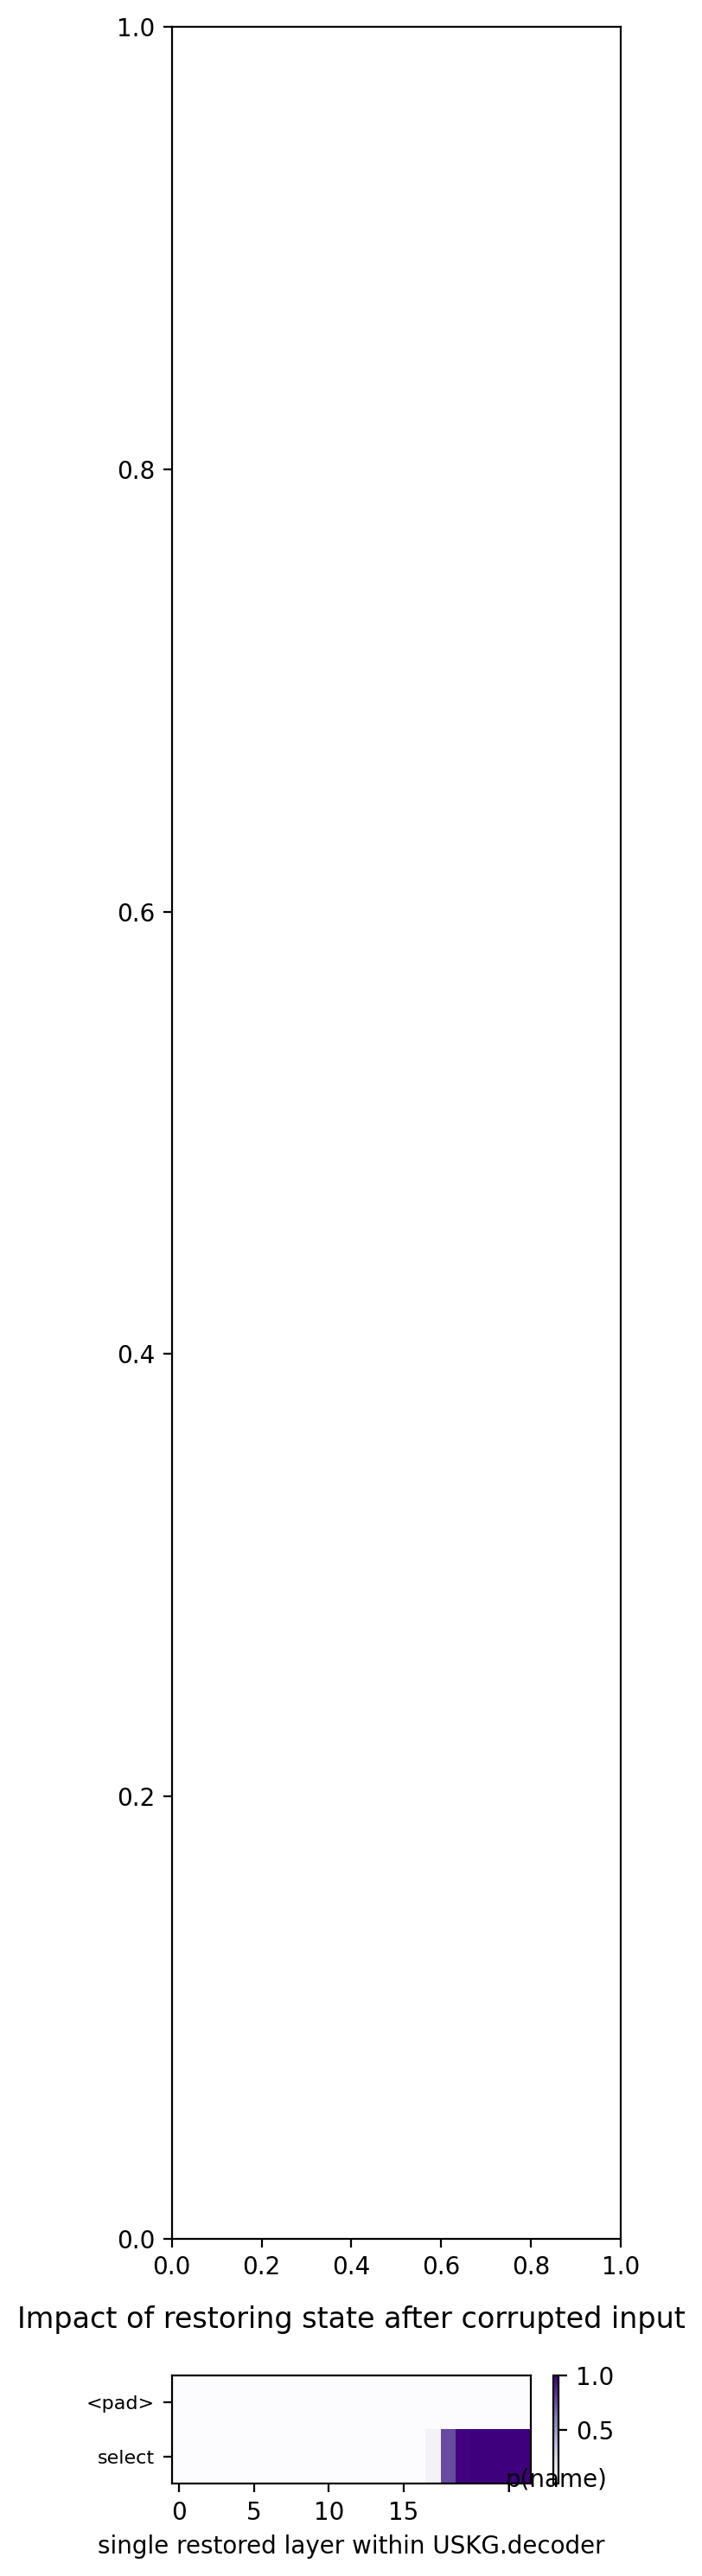

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.08', '0.77', '0.99', '1.00', '1.00', '1.00', '1.00']


In [331]:
# no sever
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

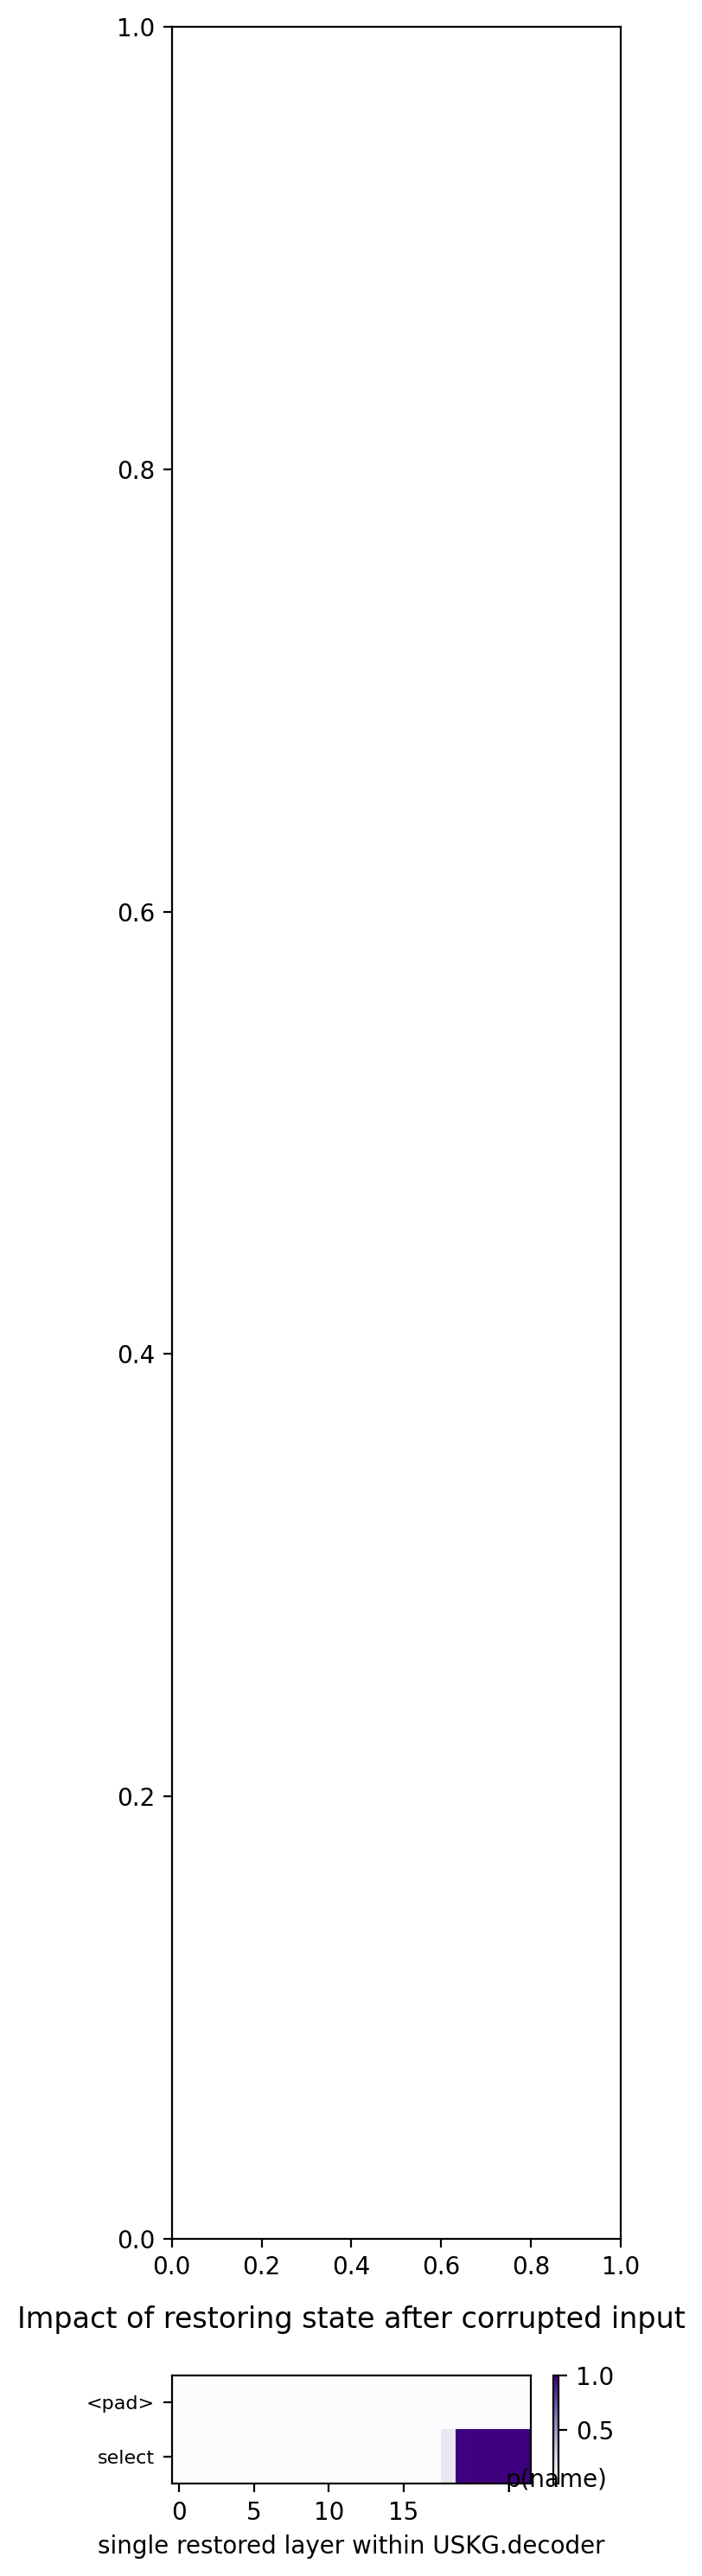

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.17', '0.99', '1.00', '1.00', '1.00', '1.00']


In [333]:
# sever cross_attn
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

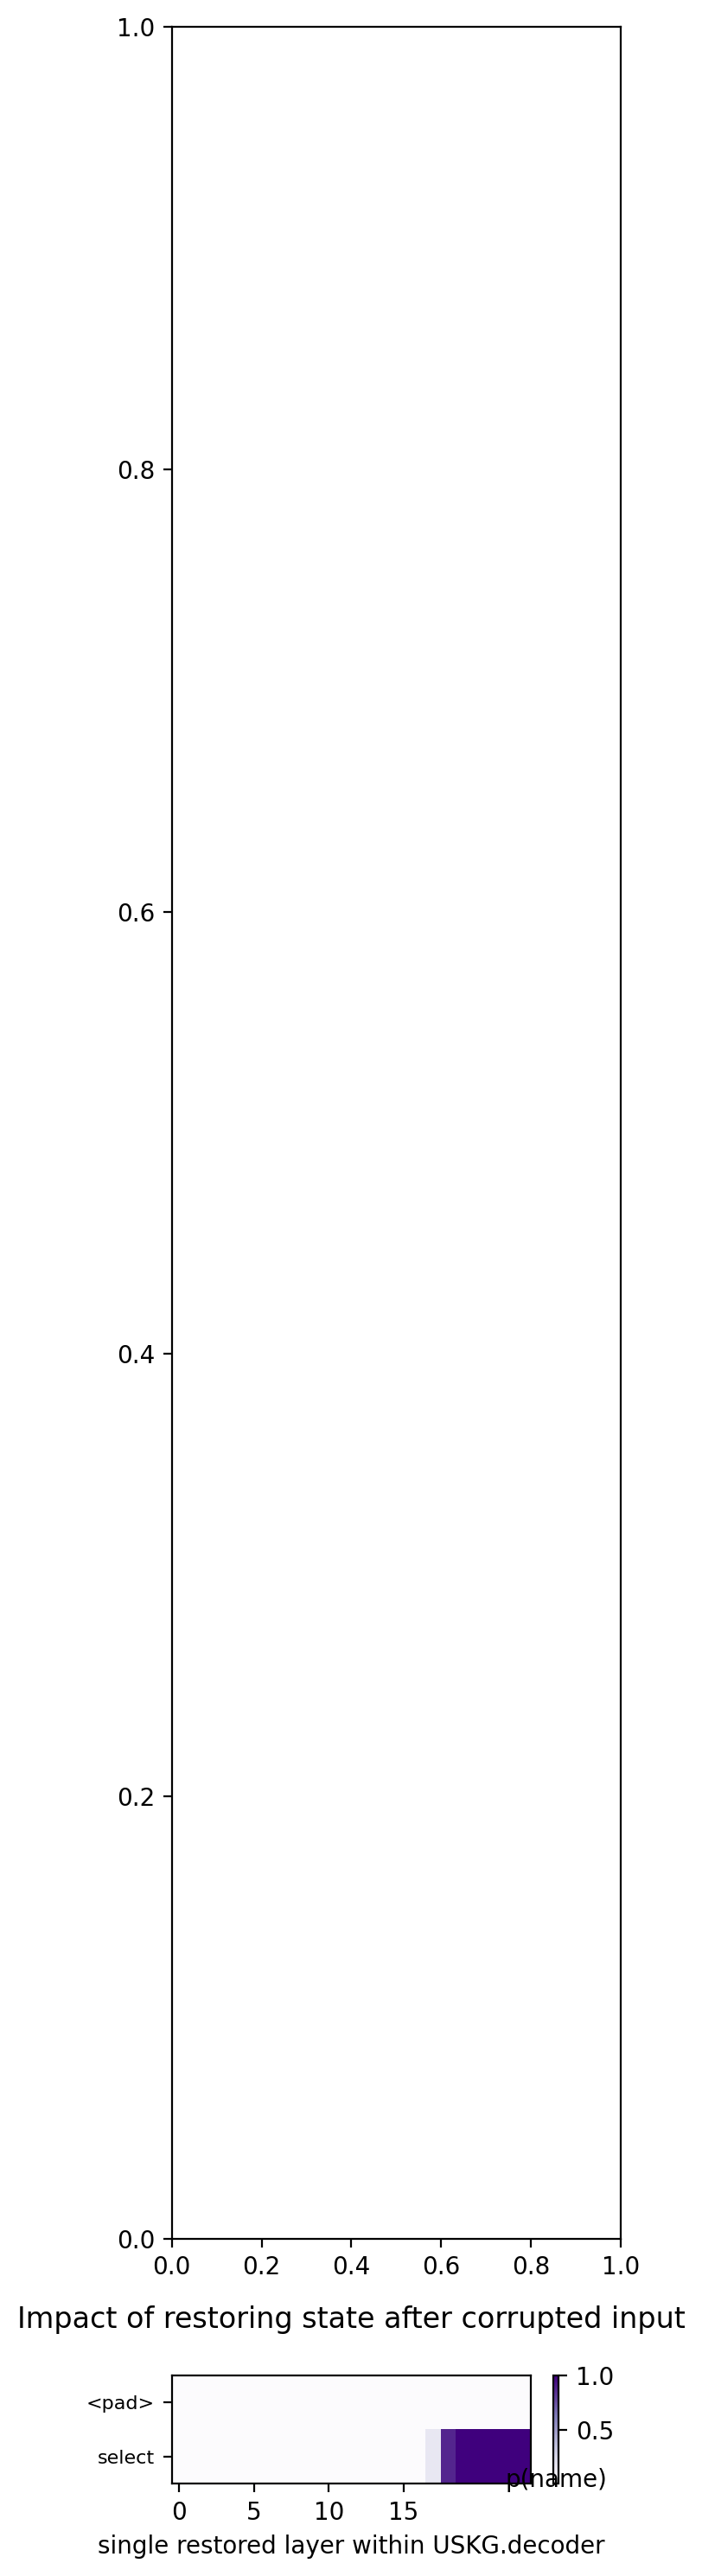

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.16', '0.88', '1.00', '1.00', '1.00', '1.00', '1.00']


In [335]:
# sever mlp; a bit better than no severing??
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

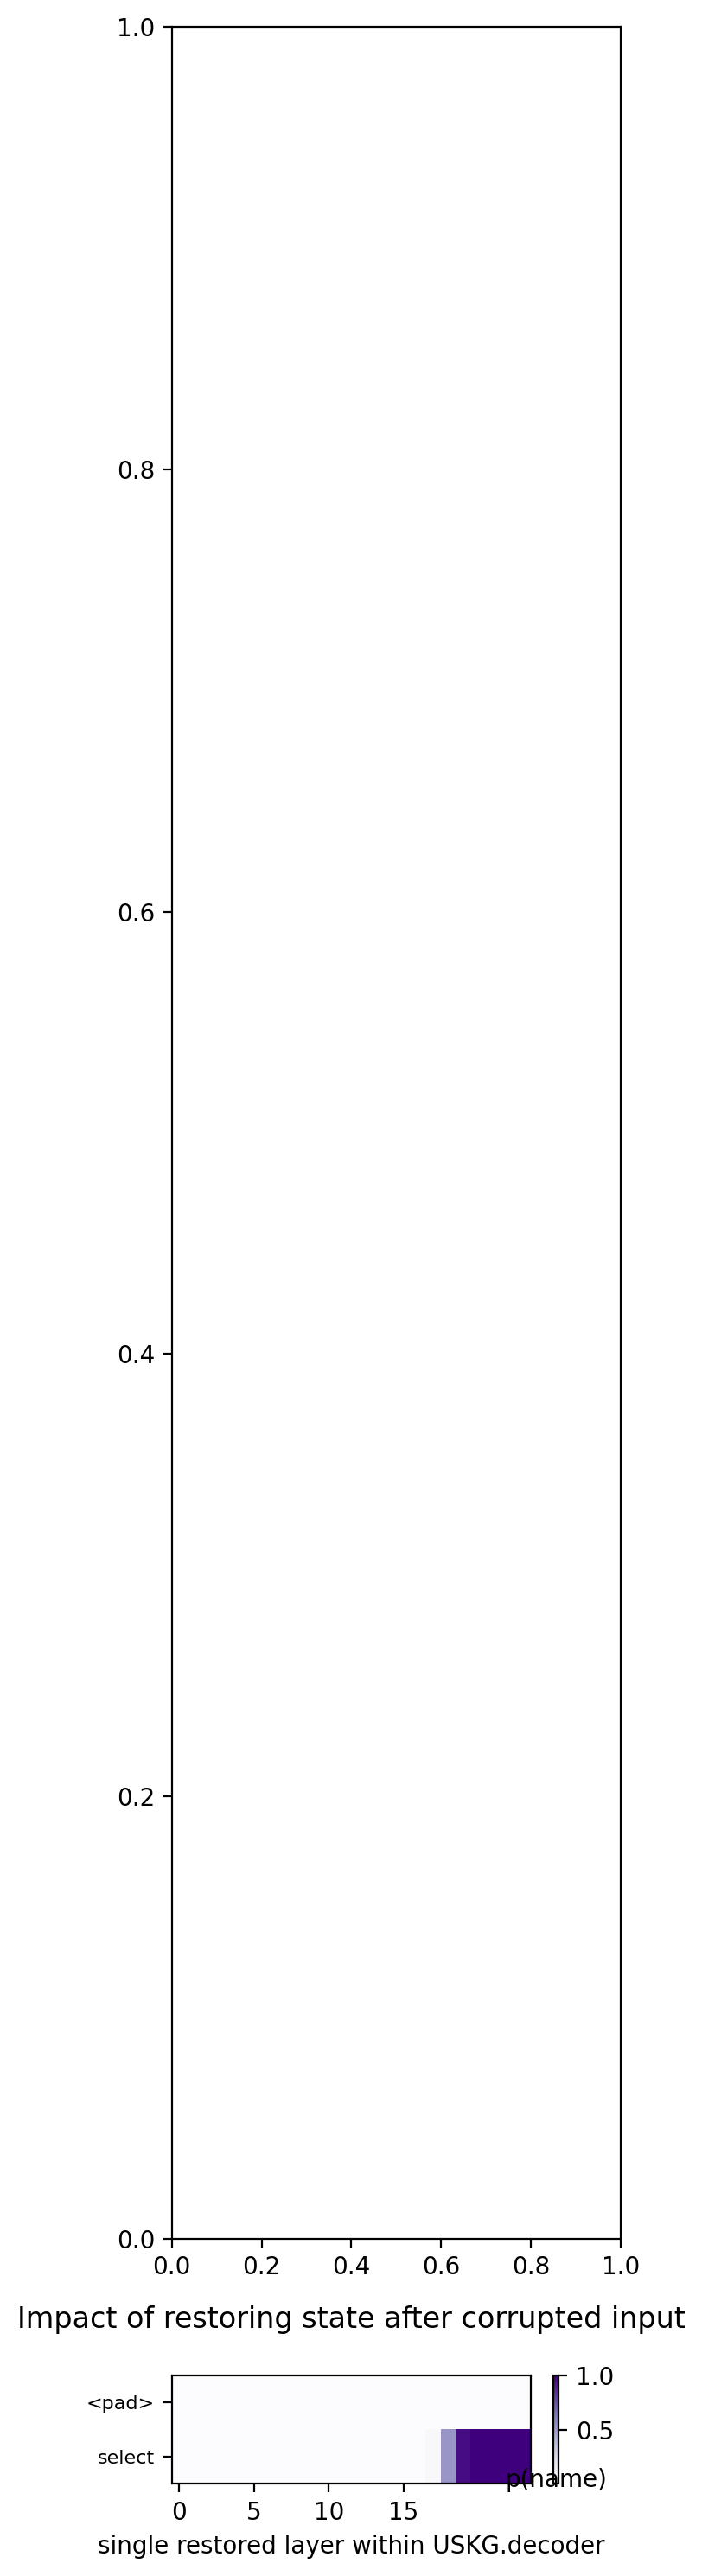

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.04', '0.52', '0.96', '1.00', '1.00', '1.00', '1.00']


In [337]:
# sever self_attn
ctu.plot_trace_heatmap_t5(result)
print([f"{s:.2f}" for s in result['scores'][1][-1]])

In [338]:
len(result['scores'][1][-1])

24

### Exp-2: dirty text recovery
- Corrupt the text, restore different parts of encoder final output
- Idea is to check the existence of contextual understanding (incorporating text info into struct representation)

#### Single sample
- ID = 2, col = 'name': (name exact match with text)
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 5, col = 'country': (no exact match, but value match with text (French) )
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 145, col = 'year': (no exact match, but value match with text (1980) )
    - none: wrong; text: correct; struct: correct; col: correct
- ID = 7, col = 'song_release_year': (multi-token, and with confusing columns in table (song_name) )
    - none: wrong; text: wrong; struct: correct; col: wrong
    - hypothesis: need clean struct to avoid confusion
- ID = 185, col = 'airportcode': (multi-token, with confusing col (airportname), but have match with text (airport code) )
    - none: wrong; text: correct; struct: wrong (2nd token); col: wrong
    - differs from hypothesis... clean struct should know sql info about the column

In [192]:
_id = 24
ex = processed_spider_dev[_id]
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('concert_singer',
 'Show the stadium name and capacity with most number of concerts in year 2014 or after.',
 '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'select t2.name, t2.capacity from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id where t1.year >= 2014 group by t2.stadium_id order by count(*) desc limit 1')

In [193]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
text_range, struct_range

((0, 17), (24, 134))

In [34]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)

col_name_ranges = token_ranges_dict['col_name_ranges']

sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')

sql_cols = set()
for t in sql_tokens:
    if t in col_name_ranges:
        sql_cols.add(t)
sql_cols

{'name', 'nationality'}

In [35]:
parsed_struct_in = ctu.parse_struct_in(struct_in)
parsed_struct_in

((1, 'orchestra', 'orchestra'),
 [((3, 'conductor', 'conductor'),
   [[(5, 'conductor_id', 'conductor_id'), []],
    [(7, 'name', 'name'), []],
    [(9, 'age', 'age'), []],
    [(11, 'nationality', 'nationality ( USA )'), [(13, 'USA', 'USA')]],
    [(16, 'year_of_work', 'year_of_work'), []]]),
  ((18, 'orchestra', 'orchestra'),
   [[(20, 'orchestra_id', 'orchestra_id'), []],
    [(22, 'orchestra', 'orchestra'), []],
    [(24, 'conductor_id', 'conductor_id'), []],
    [(26, 'record_company', 'record_company'), []],
    [(28, 'year_of_founded', 'year_of_founded'), []],
    [(30, 'major_record_format', 'major_record_format'), []]]),
  ((32, 'performance', 'performance'),
   [[(34, 'performance_id', 'performance_id'), []],
    [(36, 'orchestra_id', 'orchestra_id'), []],
    [(38, 'type', 'type'), []],
    [(40, 'date', 'date'), []],
    [(42, 'official_ratings_(millions)', 'official_ratings_(millions)'), []],
    [(44, 'weekly_rank', 'weekly_rank'), []],
    [(46, 'share', 'share'), []]]),

In [37]:
col = 'nationality'
# tok_ranges = token_ranges_dict['col_name_ranges'][col]
# tok_indices = [i for s, e in tok_ranges for i in range(s, e)]
dec_prompt = ctu.make_dec_prompt(ex['seq_out'], col)
expect = col
dec_prompt, expect

('select name from conductor where', 'nationality')

In [38]:
col_toks = token_ranges_dict['col_name_ranges'][col]
col, col_toks

('nationality', [(45, 51)])

In [39]:
# result = ctu.calculate_hidden_flow_uskg(
#     mt_uskg,
#     enc_sentence=enc_sentence,
#     dec_prompt=dec_prompt,
#     expect=col,
#     e_range=text_range,
#     enc_token_range=[],    # no analysis
#     dec_token_range=None,  # full analysis
#     tokens_to_mix_individual_indices=False,
#     replace=True,
#     sever_kind=None,
# )

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    [enc_sentence] * 11,
    [dec_prompt] * 11,
    answer=expect)

encoder_text_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in range(*text_range)
]

encoder_struct_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in range(*struct_range)
]

encoder_col_last_layer_states = [
    (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
    for tnum in col_toks
]

answer_len = len(mt_uskg.tokenizer.tokenize(expect))
answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]

In [40]:
base_score

tensor([1.0000, 1.0000], device='cuda:0')

In [41]:
## Corrupting text: expect wrong pred 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(0.1734, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(0.1734, device='cuda:0'))

In [42]:
## Restoring text encoding for decoder, but struct encoding are with dirty text encoding 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_text_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(0.9999, device='cuda:0')],
 tensor(0.9999, device='cuda:0'))

In [43]:
## Restoring clean struct encoding but dirty text encoding for decoder
## Prediction being correct means encoder final output has "contextual" or "semantic" understanding of struct_in 

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_struct_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1., device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

In [44]:
## Restoring clean col_name encoding but dirty text encoding for decoder (stricter than above)

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=encoder_col_last_layer_states,
    states_to_unpatch=[],
    answers_t=answers_t,
    tokens_to_mix=text_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

In [45]:
## For exp-2.1: mutual corruption
# First pass: corrupt text (no restore)
# Second pass: corrupt struct, no restore, reset struct output to first pass

all_ans_probs = ctu.trace_with_repatch_uskg_multi_token(
    model=mt_uskg.model,
    inp=inp,
    states_to_patch=[],
    states_to_unpatch=encoder_struct_last_layer_states,
    answers_t=answers_t,
    tokens_to_mix_1st_pass=text_range,
    tokens_to_mix=struct_range,
    tokens_to_mix_individual_indices=False,
    replace=True,
)
all_ans_probs, min(all_ans_probs)

([tensor(1.0000, device='cuda:0'), tensor(1.0000, device='cuda:0')],
 tensor(1.0000, device='cuda:0'))

#### Full dataset analysis
- +exp2.1 (text-struct-mutual)
- +exp2.1.1 (finer-grained text-struct-mutual 3x3)

In [18]:
out_dir = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction'
os.makedirs(out_dir, exist_ok=True)
res_save_path = os.path.join(out_dir, 'exp=2_dev_column.jsonl')

In [19]:
total_samples = 0
n_good_samples = 0
n_too_hard = 0      # base score < 0.5
n_too_easy = 0      # base > 0.5, base - low < 0.5

base_scores = []
low_scores = []

## len = n_good_samples
restore_scores_dict = {
    'text': [],
    'struct': [],
    'col': [],
    # 2.0.1: cancelled
    # 'ctname': [],      # col name + table name (col belongs to) 
    # 'catname': [],     # col name + all table names 
    # 'full_table': [],  # full table (col belongs to) 
    # 'all_col': [],     # all col names (regardless of table)
}

## len = total_samples
mutual_scores_dict = {
    f'{text}-{struct}': []
    for text in ['clean_t', 'dc_t', 'dirty_t']
    for struct in ['clean_s', 'dc_s', 'dirty_s']
}


In [29]:
# mutual_scores_dict
# clean_t-clean_s: base
# clean_t-dc_s: 1-pass, corrupt text, patch text
# clean_t-dirty_s: 1-pass, corrupt struct, patch text
# dc_t-clean_s: 1-pass, corrupt struct, patch struct
# dc_t-dc_s: done (prev "mutual")
# dc_t-dirty_s: 1-pass, corrupt struct
# dirty_t-clean_s: 1-pass, corrupt text, patch struct
# dirty_t-dc_s: 1-pass, corrupt text
# dirty_t-dirty_s: 1-pass, corrupt both

In [30]:
## NOTICE: this code is updated after the correct_prediction fix but not yet run!

f = open(res_save_path, 'w')

n_ex = len(processed_spider_dev)
start_id = 0

for ex_id in tqdm(range(start_id, n_ex)):
    ex = processed_spider_dev[ex_id]
    
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
    enc_tokenized = mt_uskg.tokenizer(enc_sentence)

    parsed_struct_in = ctu.parse_struct_in(struct_in)
    col2table = defaultdict(list)
    # table2full_range = dict()
    db_id_t, tables = parsed_struct_in
    for table_name_t, cols in tables:
        for col_name_t, vals in cols:
            _, table_name, _ = table_name_t
            _, col_name, _ = col_name_t
            col2table[col_name].append(table_name)
    
    text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
    token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
    col_name_ranges = token_ranges_dict['col_name_ranges']
    tab_name_ranges = token_ranges_dict['table_name_ranges']

    sql_tokens = ctu.separate_punct(ex['seq_out']).split(' ')
    sql_cols = set()
    for t in sql_tokens:
        if t in col_name_ranges:
            sql_cols.add(t)
    # Update: remove columns appearing multiple times in struct, which may differ from trend of others 
    for t in list(sql_cols):
        if len(col2table[t]) == 0:
            raise ValueError(ex_id, struct_in, t)
        elif len(col2table[t]) > 1:
            sql_cols.remove(t)
    
    ex_results = []
    
    for col in sql_cols:
        total_samples += 1
        
        dec_prompt = ctu.make_dec_prompt(ex['seq_out'], col)
        expect = col
        tab, = col2table[col]    # assert singleton by ","
        col_range, = col_name_ranges[col]
        tab_range, = tab_name_ranges[tab]
        struct_no_col_toks = [tnum for tnum in range(*struct_range) if tnum not in range(*col_range)]
        
        result = {
            "text_in": text_in,
            "struct_in": struct_in,
            "seq_out": ex['seq_out'],
            "dec_prompt": dec_prompt,
            "expect": col,
            "table": tab,
            "expect_input_range": col_range,
            "mutual_scores": dict()
        }

        inp = ctu.make_inputs_t5(
            mt_uskg.tokenizer,
            [enc_sentence] * 11,
            [dec_prompt] * 11,
            answer=expect)

        encoder_text_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*text_range)
        ]
        encoder_struct_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*struct_range)
        ]
        encoder_col_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*col_range)
        ]
        encoder_struct_no_col_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in struct_no_col_toks
        ]

        answer_len = len(mt_uskg.tokenizer.tokenize(expect))
        answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
        base_score = min(base_score).item()
        answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)
        
        result['answer'] = answer
        result['answers_t'] = answers_t.detach().cpu().numpy().tolist()
        is_correct_pred = (answer.strip() == expect)
        result['correct_prediction'] = is_correct_pred
        
        if not is_correct_pred:
            # scores don't make sense when clean pred is wrong 
            result['is_good_sample'] = False
            ex_results.append(result)
            continue
        
        """ Starting Exp2.1.1: finer grained text struct mutual """
        result['mutual_scores']['clean_t-clean_s'] = base_score
        
        # equivalent to restore_text
        result['mutual_scores']['clean_t-dc_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_text_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        result['mutual_scores']['clean_t-dirty_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_text_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=struct_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        result['mutual_scores']['dc_t-clean_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_struct_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=struct_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        ## For exp-2.1: mutual corruption
        # First pass: corrupt text (no restore)
        # Second pass: corrupt struct, no restore, reset struct output to first pass
        result['mutual_scores']['dc_t-dc_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=[],
            states_to_unpatch=encoder_struct_last_layer_states,
            answers_t=answers_t,
            tokens_to_mix_1st_pass=text_range,
            tokens_to_mix=struct_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        result['mutual_scores']['dc_t-dirty_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=[],
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=struct_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        # equivalent to restore_struct
        result['mutual_scores']['dirty_t-clean_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_struct_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        # equivalent to low_score (for text corruption)
        result['mutual_scores']['dirty_t-dc_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=[],
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        result['mutual_scores']['dirty_t-dirty_s'] = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=[],
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=list(range(*text_range)) + list(range(*struct_range)),
            tokens_to_mix_individual_indices=True,
            replace=True,
        ).item()
        
        for k in mutual_scores_dict:
            mutual_scores_dict[k].append(result['mutual_scores'][k])
        
        """ Starting Exp2: dirty text recovery """
        result['base_score'] = result['mutual_scores']['clean_t-clean_s']
        low_score = result['low_score'] = result['mutual_scores']['dirty_t-dc_s']
        # if base_score < 0.5:
        if answer.strip() != col:
            n_too_hard += 1
            result['is_good_sample'] = False
            ex_results.append(result)
            continue
        
        ## Corrupting text: expect wrong pred 
        if base_score - low_score < 0.5:
            n_too_easy += 1
            result['is_good_sample'] = False
            ex_results.append(result)
            continue
        
        n_good_samples += 1
        result['is_good_sample'] = True
        
        ## Restoring text encoding for decoder, but struct encoding are with dirty text encoding 
#         r_text_score = ctu.trace_with_repatch_uskg(
#             model=mt_uskg.model,
#             inp=inp,
#             states_to_patch=encoder_text_last_layer_states,
#             states_to_unpatch=[],
#             answers_t=answers_t,
#             tokens_to_mix=text_range,
#             tokens_to_mix_individual_indices=False,
#             replace=True,
#         ).item()
#         assert np.allclose(r_text_score, result['mutual_scores']['clean_t-dc_s']), \
#             (r_text_score, result['mutual_scores']['clean_t-dc_s'])
        r_text_score = result['mutual_scores']['clean_t-dc_s']
        
        ## Restoring clean struct encoding but dirty text encoding for decoder
#         r_struct_score = ctu.trace_with_repatch_uskg(
#             model=mt_uskg.model,
#             inp=inp,
#             states_to_patch=encoder_struct_last_layer_states,
#             states_to_unpatch=[],
#             answers_t=answers_t,
#             tokens_to_mix=text_range,
#             tokens_to_mix_individual_indices=False,
#             replace=True,
#         ).item()
#         assert np.allclose(r_struct_score, result['mutual_scores']['dirty_t-clean_s']), \
#             (r_struct_score, result['mutual_scores']['dirty_t-clean_s'])
        r_struct_score = result['mutual_scores']['dirty_t-clean_s']
        
        ## Restoring clean col_name encoding but dirty text encoding for decoder (stricter than above)
        r_col_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_col_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        ## For exp-2.1: mutual corruption
        # First pass: corrupt text (no restore)
        # Second pass: corrupt struct, no restore, reset struct output to first pass
#         mutual_corrupt_score = ctu.trace_with_repatch_uskg(
#             model=mt_uskg.model,
#             inp=inp,
#             states_to_patch=[],
#             states_to_unpatch=encoder_struct_last_layer_states,
#             answers_t=answers_t,
#             tokens_to_mix_1st_pass=text_range,
#             tokens_to_mix=struct_range,
#             tokens_to_mix_individual_indices=False,
#             replace=True,
#         ).item()

        ## Restoring struct except column of interest. Check contextualization of this column into other nodes
        r_struct_no_col_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_struct_no_col_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=text_range,
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()

        ## Restoring clean col_name encoding; corrupt all tokens. Check if only this column is enough 
        r_col_corrupt_all_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_col_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=(0, struct_range[1]),
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        
        result['r_text_score'] = r_text_score
        result['r_struct_score'] = r_struct_score
        result['r_col_score'] = r_col_score
        result['r_struct_no_col_score'] = r_struct_no_col_score
        result['r_col_corrupt_all_score'] = r_col_corrupt_all_score
#         result['m-dc_t-dc_s'] = mutual_corrupt_score
        ex_results.append(result)
        
        base_scores.append(base_score)
        low_scores.append(low_score)
        restore_scores_dict['text'].append(r_text_score)
        restore_scores_dict['struct'].append(r_struct_score)
        restore_scores_dict['col'].append(r_col_score)
        restore_scores_dict['struct_no_col'].append(r_struct_no_col_score)
        restore_scores_dict['col_corrupt_all'].append(r_col_corrupt_all_score)
#         mutual_scores_dict['dc_t-dc_s'].append(mutual_corrupt_score)

    ex_out_dict = {
        'ex_id': ex_id,
        'trace_results': ex_results,
    }
    f.write(json.dumps(ex_out_dict, indent=None) + '\n')

f.close()
total_samples, n_good_samples, n_too_hard, n_too_easy

  0%|          | 0/1034 [00:00<?, ?it/s]

(1655, 1287, 3, 365)

In [134]:
col_range

(167, 170)

In [137]:
np.mean(base_scores), np.mean(low_scores), \
np.mean(restore_scores_dict['text']), np.mean(restore_scores_dict['struct']), np.mean(restore_scores_dict['col']), \
np.mean(mutual_scores_dict['dc_t-dc_s'])

(0.9850877505823357,
 0.04326892671237934,
 0.5651500559138737,
 0.8269292973303458,
 0.6717712843135197,
 0.43050430311842003)

In [138]:
print(f'{"Score":25s}avg_gain\tperc_recover')
for score_label, high_scores in [
    ('base_scores', base_scores),
    ('restore_text_scores', restore_scores_dict['text']),
    ('restore_struct_scores', restore_scores_dict['struct']),
    ('restore_col_scores', restore_scores_dict['col']),
    ('mutual_corrupt_scores', mutual_scores_dict['dc_t-dc_s']),
]:
    avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
    perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
    print(f'{score_label:25s}{avg_gain:.4f}\t\t{perc_recover:.4f}')

Score                    avg_gain	perc_recover
base_scores              0.9418		1.0000
restore_text_scores      0.5219		0.5470
restore_struct_scores    0.7837		0.8291
restore_col_scores       0.6285		0.6752
mutual_corrupt_scores    0.3872		0.4071


In [139]:
perc_better = np.mean([(h1 - l > 0.5) and (h2 - l < 0.5)
                       for h1, h2, l in zip(restore_struct_scores, restore_text_scores, low_scores)])
perc_worse = np.mean([(h1 - l < 0.5) and (h2 - l > 0.5)
                       for h1, h2, l in zip(restore_struct_scores, restore_text_scores, low_scores)])
perc_both = np.mean([(h1 - l > 0.5) and (h2 - l > 0.5)
                       for h1, h2, l in zip(restore_struct_scores, restore_text_scores, low_scores)])
f'{perc_better:.4f} {perc_worse:.4f} {perc_both:.4f}'

'0.3465 0.0901 0.4631'

(array([246.,  39.,  42.,  45.,  39.,  37.,  53.,  46.,  72., 668.]),
 array([3.45504051e-12, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

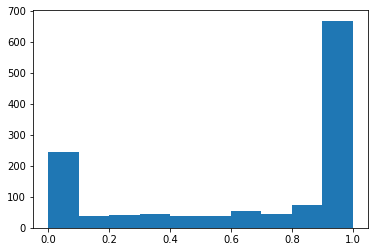

In [141]:
# check scores distribution (clutter at 0 or 1, as expected)
plt.hist(restore_scores_dict['col'])

##### Fix: correct_prediction
- changing criteria of "too hard" from "base < 0.5" to "answer being incorrect"
    - only 3 "too hard", none is changed!
- **Important update: check correct_prediction first!**

In [29]:
out_dir = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction'
in_path = os.path.join(out_dir, 'exp=2_dev_column_old_v3.jsonl')
out_path = os.path.join(out_dir, 'exp=2_dev_column.jsonl')

with open(in_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
    
len(all_samples)

1034

In [30]:
all_samples[4]['trace_results'][0]

{'text_in': 'What is the average, minimum, and maximum age of all singers from France?',
 'struct_in': '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country ( France ) , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'seq_out': "select avg(age), min(age), max(age) from singer where country = 'France'",
 'dec_prompt': 'select avg(',
 'expect': 'age',
 'table': 'singer',
 'expect_input_range': [87, 88],
 'mutual_scores': {'clean_t-clean_s': 0.9999992847442627,
  'clean_t-dc_s': 0.998543381690979,
  'clean_t-dirty_s': 0.7733225226402283,
  'dc_t-clean_s': 0.9999985098838806,
  'dc_t-dc_s': 0.9991669058799744,
  'dc_t-dirty_s': 0.8866943717002869,
  'dirty_t-clean_s': 0.999991238117218,
  'dirty_t-dc_s': 0.008637415245175362,
  'dirty_t-dirty_s': 2.0123667127336375e-05},
 'base_score': 0.999999284

In [32]:
f = open(out_path, 'w')

n_ex = len(processed_spider_dev)
start_id = 0

for ex_id in tqdm(range(start_id, n_ex)):
    ex = all_samples[ex_id]
    for r in ex['trace_results']:
        # Important update: check correct_prediction! If incorrect, all scores don't make sense 
        # "Too hard" -> correct_prediction==False
        
        text_in = r['text_in']
        struct_in = r['struct_in']
        dec_prompt = r['dec_prompt']
        col = expect = r['expect']
        
        enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
        enc_tokenized = mt_uskg.tokenizer(enc_sentence)
        
        text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
        token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
        col_name_ranges = token_ranges_dict['col_name_ranges']
        tab_name_ranges = token_ranges_dict['table_name_ranges']
        
        col_range, = col_name_ranges[col]

        inp = ctu.make_inputs_t5(
            mt_uskg.tokenizer,
            [enc_sentence] * 11,
            [dec_prompt] * 11,
            answer=expect)

        encoder_text_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*text_range)
        ]
        encoder_struct_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*struct_range)
        ]
        encoder_col_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*col_range)
        ]

        answer_len = len(mt_uskg.tokenizer.tokenize(expect))
        answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
        base_score = min(base_score).item()
        
        answer = ctu.decode_sentences(mt_uskg.tokenizer, answers_t)
        r['answer'] = answer
        r['answers_t'] = answers_t.detach().cpu().numpy().tolist()
        is_correct_pred = (answer.strip() == r['expect'])
        r['correct_prediction'] = is_correct_pred
        
        if is_correct_pred:
            r['is_good_sample'] = (r['base_score'] - r['low_score'] > 0.5)
            continue

        if (not is_correct_pred) and r['is_good_sample']:
            # change to non-good sample
            # keep the scores there for simplicity, but shouldn't use them 
            # should first check 'is_good_sample' before using
            r['is_good_sample'] = False
            n_good_samples -= 1
            continue
        
    f.write(json.dumps(ex, indent=None) + '\n')

f.close()
total_samples, n_good_samples, n_too_hard, n_too_easy

  0%|          | 0/1034 [00:00<?, ?it/s]

(0, -304, 0, 0)

##### Add scores
- +restore_struct_no_col (done)
- +restore_col_corrupt_all (done)

In [23]:
out_dir = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction'
in_path = os.path.join(out_dir, 'exp=2_dev_column_old.jsonl')
out_path = os.path.join(out_dir, 'exp=2_dev_column.jsonl')

with open(in_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
    
len(all_samples)

1034

In [24]:
all_samples[4]['trace_results'][0]

{'text_in': 'What is the average, minimum, and maximum age of all singers from France?',
 'struct_in': '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country ( France ) , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
 'seq_out': "select avg(age), min(age), max(age) from singer where country = 'France'",
 'dec_prompt': 'select avg(',
 'expect': 'age',
 'table': 'singer',
 'expect_input_range': [87, 88],
 'mutual_scores': {'clean_t-clean_s': 0.9999992847442627,
  'clean_t-dc_s': 0.998543381690979,
  'clean_t-dirty_s': 0.7733225226402283,
  'dc_t-clean_s': 0.9999985098838806,
  'dc_t-dc_s': 0.9991669058799744,
  'dc_t-dirty_s': 0.8866943717002869,
  'dirty_t-clean_s': 0.999991238117218,
  'dirty_t-dc_s': 0.008637415245175362,
  'dirty_t-dirty_s': 2.0123667127336375e-05},
 'base_score': 0.999999284

In [25]:
f = open(out_path, 'w')

n_ex = len(processed_spider_dev)
start_id = 0

for ex_id in tqdm(range(start_id, n_ex)):
    ex = all_samples[ex_id]
    for r in ex['trace_results']:
        # if not r['is_good_sample']:
        if not r['correct_prediction']:
            # for restore_col_corrupt_all, even if sample is "too easy" (corrupt text still correct),
            # can still compute this, since corrupting all tokens almost always gives wrong pred
            # However, is clean prediction is wrong, then it still doesn't make sense 
            continue
        
        text_in = r['text_in']
        struct_in = r['struct_in']
        dec_prompt = r['dec_prompt']
        col = expect = r['expect']
        
        enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
        enc_tokenized = mt_uskg.tokenizer(enc_sentence)
        
        text_range, struct_range = ctu.find_text_struct_in_range(mt_uskg.tokenizer, enc_tokenized['input_ids'])
        token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
        col_name_ranges = token_ranges_dict['col_name_ranges']
        # tab_name_ranges = token_ranges_dict['table_name_ranges']
        
        col_range, = col_name_ranges[col]
#         struct_no_col_toks = [tnum for tnum in range(*struct_range) if tnum not in range(*col_range)]

        inp = ctu.make_inputs_t5(
            mt_uskg.tokenizer,
            [enc_sentence] * 11,
            [dec_prompt] * 11,
            answer=expect)

        encoder_text_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*text_range)
        ]
#         encoder_struct_last_layer_states = [
#             (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#             for tnum in range(*struct_range)
#         ]
        encoder_col_last_layer_states = [
            (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
            for tnum in range(*col_range)
        ]
#         encoder_struct_no_col_last_layer_states = [
#             (tnum, ctu.layername_uskg(mt_uskg.model, 'encoder', mt_uskg.num_enc_layers - 1))
#             for tnum in struct_no_col_toks
#         ]
        
        answer_len = len(mt_uskg.tokenizer.tokenize(expect))
        answers_t, base_score = [d[0] for d in ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)]
        base_score = min(base_score).item()
        # r['answers_t'] = answers_t.detach().cpu().numpy().tolist()   # already added

        ## Restoring clean col_name encoding; corrupt all tokens. Check if only this column is enough 
        r_col_corrupt_all_score = ctu.trace_with_repatch_uskg(
            model=mt_uskg.model,
            inp=inp,
            states_to_patch=encoder_col_last_layer_states,
            states_to_unpatch=[],
            answers_t=answers_t,
            tokens_to_mix=(0, struct_range[1]),
            tokens_to_mix_individual_indices=False,
            replace=True,
        ).item()
        r['r_col_corrupt_all_score'] = r_col_corrupt_all_score
        
    f.write(json.dumps(ex, indent=None) + '\n')

f.close()
# total_samples, n_good_samples, n_too_hard, n_too_easy

  0%|          | 0/1034 [00:00<?, ?it/s]

#### Load & Check results

In [63]:
res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'

with open(res_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
len(all_samples)

1034

In [27]:
total_samples = 0
n_good_samples = 0
n_too_hard = 0      # wrong answer 
n_too_easy = 0      # base - low < 0.5

base_scores = []
low_scores = []

## len = n_good_samples
restore_scores_dict = {
    'text': [],
    'struct': [],
    'col': [],
    'struct_no_col': [],
    'col_corrupt_all': [],
    # 2.0.1: cancelled
    # 'ctname': [],      # col name + table name (col belongs to) 
    # 'catname': [],     # col name + all table names 
    # 'full_table': [],  # full table (col belongs to) 
    # 'all_col': [],     # all col names (regardless of table)
}

## len = total_samples
mutual_scores_dict = {
    f'{text}-{struct}': []
    for text in ['clean_t', 'dc_t', 'dirty_t']
    for struct in ['clean_s', 'dc_s', 'dirty_s']
}


In [28]:
good_samples = []

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        total_samples += 1
        if d['is_good_sample']:
            n_good_samples += 1
            d['ex_id'] = i
            good_samples.append(d)
        elif not d['correct_prediction']:
            n_too_hard += 1
        else:
            assert d['base_score'] - d['low_score'] < 0.5
            n_too_easy += 1
            
total_samples, (n_good_samples, len(good_samples)), n_too_hard, n_too_easy

(1655, (983, 983), 477, 195)

In [29]:
d.keys(), d['mutual_scores'].keys()

(dict_keys(['text_in', 'struct_in', 'seq_out', 'dec_prompt', 'expect', 'table', 'expect_input_range', 'mutual_scores', 'base_score', 'low_score', 'is_good_sample', 'r_text_score', 'r_struct_score', 'r_col_score', 'answer', 'correct_prediction', 'answers_t', 'r_struct_no_col_score', 'r_col_corrupt_all_score', 'ex_id']),
 dict_keys(['clean_t-clean_s', 'clean_t-dc_s', 'clean_t-dirty_s', 'dc_t-clean_s', 'dc_t-dc_s', 'dc_t-dirty_s', 'dirty_t-clean_s', 'dirty_t-dc_s', 'dirty_t-dirty_s']))

In [30]:
for d in good_samples:
    base_scores.append(d['base_score'])
    low_scores.append(d['low_score'])
    for k in restore_scores_dict.keys():
        restore_scores_dict[k].append(d[f'r_{k}_score'])
    for k in mutual_scores_dict.keys():
        mutual_scores_dict[k].append(d['mutual_scores'][k])

In [31]:
len(base_scores), len(restore_scores_dict['text']), len(mutual_scores_dict['dc_t-dc_s'])

(983, 983, 983)

In [32]:
# results for exp2
for k, scores in restore_scores_dict.items():
    avg = np.mean(scores)
    print(f'{k:<15s}{avg:.4f}')

text           0.5930
struct         0.8514
col            0.7269
struct_no_col  0.1234
col_corrupt_all0.7547


In [33]:
print(f'Score\tavg_gain\tperc_recover')
for score_label, high_scores in [
    ('base_scores', base_scores),
    ('restore_text_scores', restore_scores_dict['text']),
    ('restore_struct_scores', restore_scores_dict['struct']),
    ('restore_col_scores', restore_scores_dict['col']),
    ('restore_struct_no_col_scores', restore_scores_dict['struct_no_col']),
    ('restore_col_corrupt_all_scores', restore_scores_dict['col_corrupt_all']),
]:
    avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
    perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
    print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')

Score	avg_gain	perc_recover
base_scores	0.9466	1.0000
restore_text_scores	0.5491	0.5809
restore_struct_scores	0.8075	0.8576
restore_col_scores	0.6830	0.7355
restore_struct_no_col_scores	0.0795	0.0895
restore_col_corrupt_all_scores	0.7108	0.7528


In [34]:
# results for exp2.1.1 
msg = ' '*8
for k_t in ['clean_t', 'dc_t', 'dirty_t']:
    msg += f'{k_t:8s}'
msg += '\n'
for k_s in ['clean_s', 'dc_s', 'dirty_s']:
    msg += f'{k_s:8s}'
    for k_t in ['clean_t', 'dc_t', 'dirty_t']:
        k = f'{k_t}-{k_s}'
        scores = mutual_scores_dict[k]
        avg = np.mean(scores)
        msg += f'{avg:.4f}  '
    msg += '\n'
print(msg)

        clean_t dc_t    dirty_t 
clean_s 0.9905  0.9591  0.8514  
dc_s    0.5930  0.4638  0.0439  
dirty_s 0.3730  0.3263  0.0175  



#### Exp-2.1: (merged above)

In [62]:
# one-time post-processing: add "is_good_sample"=True

# res_tmp_path = os.path.join(out_dir, 'dev_column-tmp.jsonl')
# res_tmp_path, res_save_path

# with open(res_tmp_path, 'r') as f_tmp:
#     all_samples = [json.loads(l) for l in f_tmp]

# with open(res_save_path, 'w') as f:
#     for ex in all_samples:
#         for d in ex['trace_results']:
#             if 'mutual_corrupt_score' in d:
#                 assert d['base_score'] - d['low_score'] > 0.5, d
#                 d['is_good_sample'] = True
#             else:
#                 assert d['is_good_sample'] == False, d
#         f.write(json.dumps(ex) + '\n')
    

#### Exp-2.1.1 (merged)

#### Split by hardness

In [163]:
# build an index for hardness 

spider_indices_per_hardness = defaultdict(list)
spider_id2hardness = dict()

for i, ex in enumerate(processed_spider_dev):
    db_id = ex['db_id']
    sql_str = ex['seq_out']
    sql = sp_eval.get_sql(evaluator.schemas[db_id], sql_str)
    hardness = evaluator.eval_hardness(sql)
    spider_indices_per_hardness[hardness].append(i)
    spider_id2hardness[i] = hardness

[(h, len(indices)) for h, indices in spider_indices_per_hardness.items()]

[('easy', 248), ('medium', 446), ('hard', 174), ('extra', 166)]

In [191]:
spider_indices_per_hardness['extra'][:10]

[24, 25, 41, 42, 57, 58, 59, 60, 61, 62]

In [164]:
# exp2 + exp2.1.1 
# res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'

# with open(res_path, 'r') as f:
#     all_samples = [json.loads(l) for l in f]
# len(all_samples)

In [165]:
good_samples = []

for i, ex in enumerate(all_samples):
    for d in ex['trace_results']:
        if d['is_good_sample']:
            d['ex_id'] = i
            good_samples.append(d)
len(good_samples)

983

In [166]:
samples_by_hardness = defaultdict(list)

# for ex in all_samples:
#     for d in ex['trace_results']:
#         if not d['is_good_sample']:
#             continue

for d in good_samples:
#     sql_str = d['seq_out']
#     db_id = d['struct_in'].split('|')[1].strip()    # TODO: add db_id to result during experiment main run 
#     sql = sp_eval.get_sql(evaluator.schemas[db_id], sql_str)
#     hardness = evaluator.eval_hardness(sql)
    hardness = spider_id2hardness[d['ex_id']]
    samples_by_hardness[hardness].append(d)

In [167]:
[(h, len(samples)) for h, samples in samples_by_hardness.items()]

[('medium', 480), ('easy', 181), ('hard', 186), ('extra', 136)]

In [177]:
for h in ['easy', 'medium', 'hard', 'extra']:
    samples = samples_by_hardness[h]
    print(f'Hardness: {h} ({len(samples)})')
    print('[Example sql]', samples[0]['seq_out'])
    print(f'Score\tavg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_col_score',
        'r_struct_no_col_score',
        'r_col_corrupt_all_score'
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')
    print()

Hardness: easy (181)
[Example sql] select distinct country from singer where age > 20
Score	avg_gain	perc_recover
base_score	0.9572	1.0000
r_text_score	0.6232	0.6740
r_struct_score	0.8541	0.9061
r_col_score	0.7442	0.8011
r_struct_no_col_score	0.0945	0.1105
r_col_corrupt_all_score	0.7708	0.8177

Hardness: medium (480)
[Example sql] select name, country, age from singer order by age desc
Score	avg_gain	perc_recover
base_score	0.9462	1.0000
r_text_score	0.5521	0.5938
r_struct_score	0.8132	0.8688
r_col_score	0.6674	0.7188
r_struct_no_col_score	0.0577	0.0583
r_col_corrupt_all_score	0.6774	0.7208

Hardness: hard (186)
[Example sql] select song_name from singer where age > (select avg(age) from singer)
Score	avg_gain	perc_recover
base_score	0.9462	1.0000
r_text_score	0.5662	0.5914
r_struct_score	0.7303	0.7688
r_col_score	0.6793	0.7204
r_struct_no_col_score	0.0947	0.1183
r_col_corrupt_all_score	0.7154	0.7419

Hardness: extra (136)
[Example sql] select t2.name, t2.location from concert as t1 jo

#### Split by column role

In [169]:
role_keyword_pattern = r'\W(select|where|join|group by|having|order by)\W'

In [170]:
_sql_str = samples_by_hardness['extra'][0]['seq_out']
_sql_str

'select t2.name, t2.location from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id where t1.year = 2014 intersect select t2.name, t2.location from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id where t1.year = 2015'

In [171]:
re.findall(role_keyword_pattern, ' ' + _sql_str + ' ')

['select', 'join', 'where', 'select', 'join', 'where']

In [172]:
def _detect_column_role(dec_prompt):
    role_keyword_pattern = r'\W(select|where|join|group by|having|order by)\W'
    all_kws = re.findall(role_keyword_pattern, ' ' + dec_prompt + ' ')
    assert len(all_kws) > 0, dec_prompt
    col_role_kw = all_kws[-1]
    return col_role_kw

In [173]:
samples_by_column_role = defaultdict(list)

for d in good_samples:
#     all_kws = re.findall(role_keyword_pattern, ' ' + d['dec_prompt'] + ' ')
#     assert len(all_kws) > 0, d['dec_prompt']
#     col_role_kw = all_kws[-1]
    col_role_kw = _detect_column_role(d['dec_prompt'])
    samples_by_column_role[col_role_kw].append(d)

[(r, len(samples)) for r, samples in samples_by_column_role.items()]

[('select', 632),
 ('where', 231),
 ('order by', 57),
 ('join', 60),
 ('group by', 1),
 ('having', 2)]

In [176]:
for r in samples_by_column_role.keys():
    samples = samples_by_column_role[r]
    if len(samples) < 10:
        continue
    print(f'Column role: {r} ({len(samples)})')
    print('[Example prompt]', samples[0]['dec_prompt'])
    print(f'Score\tavg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_col_score',
        'r_struct_no_col_score',
        'r_col_corrupt_all_score'
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')
    print()

Column role: select (632)
[Example prompt] select name, country,
Score	avg_gain	perc_recover
base_score	0.9639	1.0000
r_text_score	0.6161	0.6519
r_struct_score	0.7748	0.8070
r_col_score	0.6741	0.7184
r_struct_no_col_score	0.0500	0.0475
r_col_corrupt_all_score	0.6990	0.7278

Column role: where (231)
[Example prompt] select avg(age), min(age), max(age) from singer where
Score	avg_gain	perc_recover
base_score	0.9186	1.0000
r_text_score	0.5183	0.5584
r_struct_score	0.8727	0.9654
r_col_score	0.8211	0.9091
r_struct_no_col_score	0.0841	0.1212
r_col_corrupt_all_score	0.7374	0.8139

Column role: order by (57)
[Example prompt] select song_name, song_release_year from singer order by
Score	avg_gain	perc_recover
base_score	0.9447	1.0000
r_text_score	0.4849	0.5263
r_struct_score	0.9077	0.9649
r_col_score	0.8048	0.8596
r_struct_no_col_score	-0.0102	0.0000
r_col_corrupt_all_score	0.5500	0.5789

Column role: join (60)
[Example prompt] select t2.countryname from car_makers as t1 join countries as t2 on

In [35]:
# res_path = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'
# with open(res_path, 'r') as f:
#     all_samples = [json.loads(l) for l in f]
# len(all_samples)

#### Split by text match

In [64]:
len(all_samples)

1034

In [ ]:
ctu.RAT_SQL_RELATION_ID2NAME
REL2ID = {v : k for k, v in ctu.RAT_SQL_RELATION_ID2NAME.items()}
REL2ID

In [ ]:
all_samples[2]

In [ ]:
processed_spider_dev[2]

In [68]:
rel_matrix = np.array(json.loads(processed_spider_dev[2]['rat_sql_graph']['relations']), dtype=int)
rel_matrix.shape

(45, 45)

In [69]:
xs, ys = np.where(rel_matrix == 42)
list(zip(xs, ys))

[(27, 8), (40, 8)]

In [70]:
_nodes = processed_spider_dev[2]['rat_sql_graph']['nodes']

for x, y in zip(xs, ys):
    print(_nodes[x], _nodes[y])

<C>singer::singer_id singer
<C>singer_in_concert::singer_id singer


In [ ]:
ctu.parse_struct_in(spider_ex['struct_in'])

In [181]:
def _check_text_match(spider_ex, col, tab=None):
    # col = result_d['expect']
    # tab = result_d['table']
    # node_name = f'<C>{tab}::{col}'
    nodes = spider_ex['rat_sql_graph']['nodes']
    
    """ TODO: if tab not given, infer from parsed_struct_in (first appearing col name) """
    if tab is None:
        raise NotImplementedError
    
    struct_in = spider_ex['struct_in']
    
    # use struct_in to find column id in table and table id; use these to index ratsql node
    db_id, tables = ctu.parse_struct_in(spider_ex['struct_in'])
    for tid, (tab_name_t, cols) in enumerate(tables):
        if tab_name_t[1] != tab:
            continue
        for cid, (col_name_t, vals) in enumerate(cols):
            if col_name_t[1] != col:
                continue
            # Found the node table/column; save them 
            node_tid = tid
            node_cid = cid
            break
            
    all_tab_nodes = [n for n in nodes if n.startswith('<T>')]
    tab_node = all_tab_nodes[node_tid]
    ratsql_tab_name = tab_node.split('<T>')[1]
    tab_prefix = f'<C>{ratsql_tab_name}::'
    tab_all_col_nodes = [n for n in nodes if n.startswith(tab_prefix)]
    col_node = tab_all_col_nodes[node_cid]
    node_idx = nodes.index(col_node)
    
    rel_matrix = json.loads(spider_ex['rat_sql_graph']['relations'])
    rel_row = rel_matrix[node_idx]
    
    if REL2ID['cqCEM'] in rel_row:
        return 'exact'
    elif REL2ID['cqCPM'] in rel_row:
        return 'partial'
    else:
        return 'no-match'
    

In [182]:
d = good_samples[244]
spider_ex = processed_spider_dev[d['ex_id']]
col = d['expect']
tab = d['table']
d['table'], d['expect'], d['text_in'], _check_text_match(spider_ex, col, tab)

('shop',
 'number_products',
 'Sort all the shops by number products in descending order, and return the name, location and district of each shop.',
 'exact')

In [148]:
samples_by_text_match = {k: [] for k in ['exact', 'partial', 'no-match']}

for d in good_samples:
    spider_ex = processed_spider_dev[d['ex_id']]
    text_match = _check_text_match(spider_ex, d)
    samples_by_text_match[text_match].append(d)

[(m, len(samples)) for m, samples in samples_by_text_match.items()]

[('exact', 553), ('partial', 159), ('no-match', 271)]

In [154]:
for m in ['exact', 'partial', 'no-match']:
    samples = samples_by_text_match[m]
    print(f'Text match: {m} ({len(samples)})')
    print('[Example]', samples[0]['text_in'])
    print(f"[Example] {samples[0]['dec_prompt']} *{samples[0]['expect']}*")
    print(f'Score\tavg_gain\tperc_recover')
    
    low_scores = [d['low_score'] for d in samples]
    for score_label in [
        'base_score',
        'r_text_score',
        'r_struct_score',
        'r_col_score',
        'r_struct_no_col_score',
        'r_col_corrupt_all_score'
#         'm-dc_t-dc_s-score',
    ]:
        high_scores = [d[score_label] for d in samples]
        avg_gain = np.mean([h - l for h, l in zip(high_scores, low_scores)])
        perc_recover = np.mean([h - l > 0.5 for h, l in zip(high_scores, low_scores)])
        print(f'{score_label}\t{avg_gain:.4f}\t{perc_recover:.4f}')
    print()

Text match: exact (553)
[Example] Show name, country, age for all singers ordered by age from the oldest to the youngest.
[Example] select name, country, *age*
Score	avg_gain	perc_recover
base_score	0.9501	1.0000
r_text_score	0.7393	0.7830
r_struct_score	0.7989	0.8517
r_col_score	0.6998	0.7468
r_struct_no_col_score	0.0679	0.0723
r_col_corrupt_all_score	0.7193	0.7595

Text match: partial (159)
[Example] Show the name and the release year of the song by the youngest singer.
[Example] select song_name, *song_release_year*
Score	avg_gain	perc_recover
base_score	0.9513	1.0000
r_text_score	0.2488	0.2767
r_struct_score	0.7862	0.8239
r_col_score	0.6924	0.7484
r_struct_no_col_score	0.0420	0.0692
r_col_corrupt_all_score	0.5945	0.6415

Text match: no-match (271)
[Example] What is the average, minimum, and maximum age of all singers from France?
[Example] select avg(age), min(age), max(age) from singer where *country*
Score	avg_gain	perc_recover
base_score	0.9366	1.0000
r_text_score	0.3370	0.3469


In [200]:
ex = samples_by_text_match['no-match'][50]

In [202]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in} The database is as following: {struct_in}"

f"{enc_sentence} => {ex['seq_out']}"

"What are the names of all European countries with at least 3 manufacturers? The database is as following: | car_1 | continents : contid , continent ( europe ) | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year => select t1.countryname from countries as t1 join continents as t2 on t1.continent = t2.contid join car_makers as t3 on t1.countryid = t3.country where t2.continent = 'europe' group by t1.countryname having count(*) >= 3;"

In [203]:
ex['ex_id']

130

### Exp-2.2: dirty text struct restore

In [37]:
# # one-time patching: result['enc_token_range'] = enc_token_range

# in_path = f'/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column_old_v1.jsonl'
# out_path = f'/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column.jsonl'

# with open(in_path, 'r') as f:
#     all_samples = [json.loads(l) for l in f]
    
# for ex_id in range(len(all_samples)):
#     ex = all_samples[ex_id]
#     spider_ex = processed_spider_dev[ex_id]
    
#     text_in = spider_ex['text_in']
#     struct_in = spider_ex['struct_in']
#     enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
#     enc_tokenized = mt_uskg.tokenizer(enc_sentence)

#     token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], struct_in)
#     col_name_ranges = token_ranges_dict['col_name_ranges']
    
#     for r in ex['trace_results']:
#         if not (r['correct_prediction'] and r['is_good_sample']):
#             continue
        
#         node = r['target_node']
#         tok_ranges = col_name_ranges[node]
#         enc_token_range = [[i for s, e in tok_ranges for i in range(s, e)]]
#         r['enc_token_range'] = enc_token_range

# with open(out_path, 'w') as f:
#     for ex in all_samples:
#         f.write(json.dumps(ex, indent=None) + '\n')

#### Load & Plotting results

In [217]:
res_json_path = f'/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column.jsonl'

with open(res_json_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]

good_trace_results = []
for ex in all_samples:
    for r in ex['trace_results']:
        if r['is_good_sample']:
            r['ex_id'] = ex['ex_id']
            good_trace_results.append(r)
    
len(all_samples), len(good_trace_results)

(1034, 983)

In [ ]:
good_trace_results[0]

In [ ]:
# # Generating all plots
# fig_save_dir = f'/home/yshao/Projects/rome/results/figs/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column'

# for i, r in enumerate(tqdm(good_trace_results)):
#     result = dict(r)

#     enc_s, dec_s = result['scores']
    
#     # enc_s = np.array(enc_s)
#     enc_layers_vec = np.array(enc_s[0])
#     assert enc_layers_vec.shape == (mt_uskg.num_enc_layers,)
#     enc_token_range, = result['enc_token_range']
    
#     enc_s = np.zeros((len(result['input_tokens']), mt_uskg.num_enc_layers))
#     enc_s[enc_token_range] = enc_layers_vec
    
#     dec_s = np.zeros((len(result['dec_input_tokens']), mt_uskg.num_dec_layers))
#     result['scores'] = [enc_s, dec_s]

#     ex_id = r['ex_id']
#     ctu.plot_trace_heatmap_t5(result, savepdf=os.path.join(fig_save_dir, f'{i}-ex_id={ex_id}.pdf'))
    

#### Check avg per layer

In [223]:
scores_per_layer = [[] for _ in range(mt_uskg.num_enc_layers)]

for r in good_trace_results:
    enc_s, dec_s = r['scores']
    for l, s in enumerate(enc_s[0]):
        scores_per_layer[l].append(s)

In [224]:
avg_by_layer = [np.mean(scores) for scores in scores_per_layer]
avg_by_layer

[0.04524680863619921,
 0.04823612960266694,
 0.05050564487260127,
 0.05117493436306537,
 0.05102834660817652,
 0.054566656168091233,
 0.06774559314524954,
 0.07099460938245039,
 0.11058849725319542,
 0.1448350074068227,
 0.17444474233965226,
 0.20740230451881006,
 0.26972563701313523,
 0.343722437901298,
 0.3446454598649206,
 0.3750752314326425,
 0.44991763415652863,
 0.42479658773356327,
 0.44894314747310937,
 0.500455887096794,
 0.511449336873387,
 0.6113965333640995,
 0.6624105991627,
 0.7269043749944363]

In [225]:
print('Layer\tAvg. Score')
for l, avg in enumerate(avg_by_layer):
    print(f'{l:<5d}\t{avg:.4f}')

Layer	Avg. Score
0    	0.0452
1    	0.0482
2    	0.0505
3    	0.0512
4    	0.0510
5    	0.0546
6    	0.0677
7    	0.0710
8    	0.1106
9    	0.1448
10   	0.1744
11   	0.2074
12   	0.2697
13   	0.3437
14   	0.3446
15   	0.3751
16   	0.4499
17   	0.4248
18   	0.4489
19   	0.5005
20   	0.5114
21   	0.6114
22   	0.6624
23   	0.7269


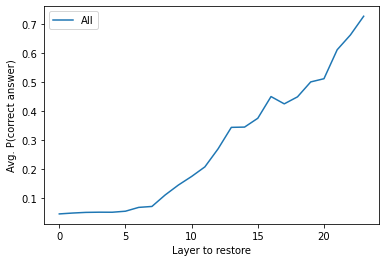

In [226]:
fig, ax = plt.subplots(1, 1)
ax.plot(avg_by_layer, label='All')
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

####  by hardness 

In [236]:
# {h : [[score], ...]}
scores_by_hardness = {hardness : [] for hardness in ['easy', 'medium', 'hard', 'extra']}   

for r in good_trace_results:
    enc_s, dec_s = r['scores']
    scores, = enc_s
    hardness = spider_id2hardness[r['ex_id']]
    scores_by_hardness[hardness].append(scores)

[(h, len(scores)) for h, scores in scores_by_hardness.items()]

[('easy', 181), ('medium', 480), ('hard', 186), ('extra', 136)]

In [237]:
for h, sample_scores in scores_by_hardness.items():
    print(h)
    scores_by_layer = zip(*sample_scores)
    avg_by_layer = [np.mean(scores) for scores in scores_by_layer]
    print([f'{avg:.2f}' for avg in avg_by_layer])
    print()

easy
['0.04', '0.05', '0.05', '0.05', '0.05', '0.06', '0.08', '0.08', '0.14', '0.20', '0.23', '0.28', '0.34', '0.41', '0.40', '0.42', '0.48', '0.47', '0.49', '0.54', '0.54', '0.65', '0.71', '0.78']

medium
['0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.07', '0.07', '0.11', '0.14', '0.17', '0.19', '0.26', '0.34', '0.34', '0.37', '0.43', '0.40', '0.43', '0.48', '0.49', '0.59', '0.65', '0.72']

hard
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.06', '0.06', '0.10', '0.13', '0.16', '0.19', '0.26', '0.33', '0.35', '0.39', '0.47', '0.45', '0.45', '0.51', '0.51', '0.59', '0.64', '0.72']

extra
['0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.07', '0.07', '0.10', '0.12', '0.15', '0.17', '0.23', '0.30', '0.29', '0.32', '0.44', '0.41', '0.46', '0.53', '0.54', '0.66', '0.68', '0.71']



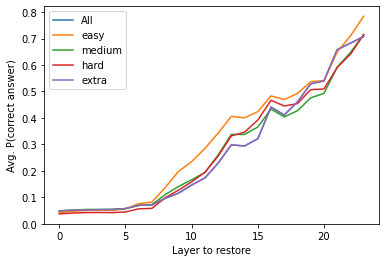

In [238]:
fig, ax = plt.subplots()
ax.plot(avg_by_layer, label='All')
for h, sample_scores in scores_by_hardness.items():
    h_scores_by_layer = zip(*sample_scores)
    h_avg_by_layer = [np.mean(scores) for scores in h_scores_by_layer]
    ax.plot(h_avg_by_layer, label=h)
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

####  by column role 

In [239]:
# {h : [[score], ...]}
scores_by_column_role = defaultdict(list)

for r in good_trace_results:
    enc_s, dec_s = r['scores']
    scores, = enc_s
    role = _detect_column_role(' '.join(r['dec_input_tokens']))
    scores_by_column_role[role].append(scores)

[(r, len(scores)) for r, scores in scores_by_column_role.items()]

[('select', 631),
 ('where', 232),
 ('order by', 57),
 ('join', 60),
 ('group by', 1),
 ('having', 2)]

In [240]:
for r, sample_scores in scores_by_column_role.items():
    if len(sample_scores) < 10:
        continue
    print(r)
    scores_by_layer = zip(*sample_scores)
    avg_by_layer = [np.mean(scores) for scores in scores_by_layer]
    print([f'{avg:.2f}' for avg in avg_by_layer])
    print()

select
['0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.03', '0.04', '0.04', '0.06', '0.07', '0.09', '0.13', '0.18', '0.17', '0.19', '0.26', '0.24', '0.28', '0.34', '0.36', '0.53', '0.60', '0.70']

where
['0.08', '0.09', '0.10', '0.10', '0.10', '0.12', '0.16', '0.17', '0.32', '0.41', '0.49', '0.57', '0.67', '0.78', '0.79', '0.84', '0.91', '0.89', '0.89', '0.92', '0.91', '0.89', '0.89', '0.90']

order by
['0.05', '0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.06', '0.08', '0.10', '0.14', '0.19', '0.35', '0.60', '0.59', '0.68', '0.82', '0.72', '0.74', '0.83', '0.84', '0.82', '0.84', '0.86']

join
['0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.06', '0.07', '0.07', '0.09', '0.14', '0.21', '0.21', '0.23', '0.31', '0.29', '0.30', '0.32', '0.29', '0.26', '0.25', '0.22']



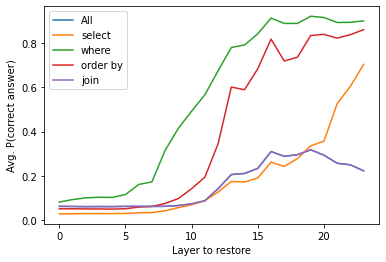

In [241]:
fig, ax = plt.subplots()
ax.plot(avg_by_layer, label='All')
for r, sample_scores in scores_by_column_role.items():
    if len(sample_scores) < 10:
        continue
    r_scores_by_layer = zip(*sample_scores)
    r_avg_by_layer = [np.mean(scores) for scores in r_scores_by_layer]
    ax.plot(r_avg_by_layer, label=r)
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

#### by text matching

In [244]:
scores_by_text_matching = {k: [] for k in ['exact', 'partial', 'no-match']}

for r in good_trace_results:
    spider_ex = processed_spider_dev[r['ex_id']]
    col = r['target_node']
    tab = r['target_node_table']
    m = _check_text_match(spider_ex, col, tab)

    enc_s, dec_s = r['scores']
    scores, = enc_s
    scores_by_text_matching[m].append(scores)

[(m, len(samples)) for m, samples in scores_by_text_matching.items()]

[('exact', 553), ('partial', 159), ('no-match', 271)]

In [245]:
for r, sample_scores in scores_by_text_matching.items():
    if len(sample_scores) < 10:
        continue
    print(r)
    scores_by_layer = zip(*sample_scores)
    avg_by_layer = [np.mean(scores) for scores in scores_by_layer]
    print([f'{avg:.2f}' for avg in avg_by_layer])
    print()

exact
['0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.07', '0.07', '0.12', '0.16', '0.19', '0.22', '0.27', '0.33', '0.33', '0.36', '0.43', '0.40', '0.42', '0.48', '0.50', '0.62', '0.67', '0.74']

partial
['0.04', '0.04', '0.04', '0.04', '0.04', '0.04', '0.05', '0.05', '0.07', '0.09', '0.11', '0.13', '0.21', '0.30', '0.30', '0.34', '0.43', '0.42', '0.46', '0.51', '0.51', '0.61', '0.67', '0.73']

no-match
['0.05', '0.05', '0.05', '0.05', '0.05', '0.06', '0.08', '0.08', '0.12', '0.15', '0.19', '0.23', '0.31', '0.40', '0.40', '0.43', '0.51', '0.48', '0.50', '0.55', '0.54', '0.59', '0.64', '0.69']



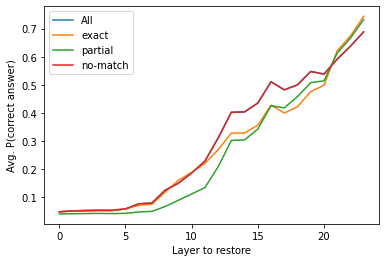

In [246]:
fig, ax = plt.subplots()
ax.plot(avg_by_layer, label='All')
for m, sample_scores in scores_by_text_matching.items():
    if len(sample_scores) < 10:
        continue
    r_scores_by_layer = zip(*sample_scores)
    r_avg_by_layer = [np.mean(scores) for scores in r_scores_by_layer]
    ax.plot(r_avg_by_layer, label=m)
ax.set_xlabel('Layer to restore')
ax.set_ylabel('Avg. P(correct answer)')
ax.legend()

#### post-proc: adding info to result dict
- +table (done)

In [206]:
in_path = f'/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column_old.jsonl'
out_path = f'/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column.jsonl'
ref_path = f'/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'

with open(in_path, 'r') as f:
    all_samples = [json.loads(l) for l in f]
with open(ref_path, 'r') as f:
    ref_samples = [json.loads(l) for l in f]
    
len(all_samples), len(ref_samples)

(1034, 1034)

In [210]:
all_samples[2]['trace_results'][0].keys(), ref_samples[2]['trace_results'][0].keys()

(dict_keys(['low_score', 'high_score', 'input_ids', 'input_tokens', 'dec_input_ids', 'dec_input_tokens', 'subject_range', 'subject_range_individual_indices', 'answer', 'window', 'correct_prediction', 'kind', 'sever_kind', 'scores', 'is_good_sample', 'target_node', 'db_id', 'enc_token_range']),
 dict_keys(['text_in', 'struct_in', 'seq_out', 'dec_prompt', 'expect', 'table', 'expect_input_range', 'mutual_scores', 'base_score', 'low_score', 'is_good_sample', 'r_text_score', 'r_struct_score', 'r_col_score', 'answer', 'correct_prediction', 'answers_t', 'r_struct_no_col_score', 'r_col_corrupt_all_score']))

In [215]:
for i, (ex, ref_ex) in enumerate(zip(all_samples, ref_samples)):
    cols = set([d['target_node'] for d in ex['trace_results']])
    ref_cols = set([d['expect'] for d in ref_ex['trace_results']])
    assert cols == ref_cols, (cols, ref_cols)
    
    _c2t = {d['expect'] : d['table'] for d in ref_ex['trace_results']}
    for d in ex['trace_results']:
        col = d['target_node']
        tab = _c2t[col]
        d['target_node_table'] = tab

In [216]:
with open(out_path, 'w') as f:
    for ex in all_samples:
        f.write(json.dumps(ex, indent=None) + '\n')

## USKG error analysis

In [335]:
# adapted from play_pred()

def pred_sql(mt, ex):
    text_in = ex['text_in']
    struct_in = ex['struct_in']

    txt = f"{text_in}; structed knowledge: {struct_in}"
    
    tokenized_txt = mt.tokenizer_uskg([txt], max_length=1024, padding="max_length", truncation=True)
    
    device = mt.model.device
    pred = mt.tokenizer_uskg.batch_decode(
      mt.model.generate(
        torch.tensor(tokenized_txt.data['input_ids'], dtype=int, device=device),
        torch.tensor(tokenized_txt.data['attention_mask'], dtype=int, device=device),
        num_beams=1, 
        max_length=256
        ), 
      skip_special_tokens=True 
    )
    return pred[0]


In [336]:
# adapted from evaluator.evaluate_one()

def evaluate_sql(evaluator, db_name, gold, predicted):
    schema = evaluator.schemas[db_name]
    g_sql = sp_eval.get_sql(schema, gold)
    hardness = evaluator.eval_hardness(g_sql)
    # self.scores[hardness]["count"] += 1
    # self.scores["all"]["count"] += 1

    parse_error = False
    try:
        p_sql = sp_eval.get_sql(schema, predicted)
    except:
        # If p_sql is not valid, then we will use an empty sql to evaluate with the correct sql
        p_sql = {
            "except": None,
            "from": {"conds": [], "table_units": []},
            "groupBy": [],
            "having": [],
            "intersect": None,
            "limit": None,
            "orderBy": [],
            "select": [False, []],
            "union": None,
            "where": [],
        }

        # TODO fix
        parse_error = True

    # rebuild sql for value evaluation
    kmap = evaluator.kmaps[db_name]
    g_valid_col_units = sp_eval.build_valid_col_units(g_sql["from"]["table_units"], schema)
    g_sql = sp_eval.rebuild_sql_val(g_sql)
    g_sql = sp_eval.rebuild_sql_col(g_valid_col_units, g_sql, kmap)
    p_valid_col_units = sp_eval.build_valid_col_units(p_sql["from"]["table_units"], schema)
    p_sql = sp_eval.rebuild_sql_val(p_sql)
    p_sql = sp_eval.rebuild_sql_col(p_valid_col_units, p_sql, kmap)
    
    exec_score = None
    partial_scores = None
    exact_score = None
    if evaluator.etype in ["all", "exec"]:
        exec_score = sp_eval.eval_exec_match(
            evaluator.db_paths[db_name], predicted, gold, p_sql, g_sql
        )
        exec_score = int(exec_score)
    if evaluator.etype in ["all", "match"]:
        partial_scores = evaluator.eval_partial_match(p_sql, g_sql)
        exact_score = evaluator.eval_exact_match(p_sql, g_sql, partial_scores)
        # update_scores_match(self.scores, exact_score, hardness, partial_scores, PARTIAL_TYPES)

    return {
        "predicted": predicted,
        "gold": gold,
        "predicted_parse_error": parse_error,
        "hardness": hardness,
        "exact": exact_score,
        "partial": partial_scores,
        "exec": exec_score,
    }

In [354]:
db_dir = '/home/yshao/Projects/language/language/xsp/data/spider/database'

def execute_sql(db, sql_str):
    db_path = os.path.join(db_dir, db, f'{db}.sqlite')
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute(sql_str)
        res = cursor.fetchall()
    except:
        res = 'ERROR'
    conn.close()
    return res

In [403]:
ex = processed_spider_dev[503]
ex.keys()

dict_keys(['query', 'question', 'db_id', 'db_path', 'db_table_names', 'db_column_names', 'db_column_types', 'db_primary_keys', 'db_foreign_keys', 'rat_sql_graph', 'serialized_schema', 'struct_in', 'text_in', 'seq_out'])

In [404]:
pred = pred_sql(mt_uskg, ex)
ex['db_id'], ex['text_in'], ex['seq_out'], pred

('battle_death',
 "How many battles did not lose any ship with tonnage '225'?",
 "select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );",
 'select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage > 225 )')

In [ ]:
text_in = ex['text_in']
struct_in = ex['struct_in']
txt = f"{text_in}; structed knowledge: {struct_in}"
txt_toks = mt_uskg.tokenizer_uskg.tokenize(txt)
len(txt_toks)

In [ ]:
txt_toks

In [405]:
exec_res = execute_sql(ex['db_id'], ex['seq_out'])
ex['seq_out'], exec_res

("select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );",
 [(7,)])

In [406]:
exec_res = execute_sql(ex['db_id'], pred)
pred, exec_res

('select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage > 225 )',
 [(3,)])

In [407]:
chatgpt_pred = """
SELECT COUNT(DISTINCT battle.id) AS num_battles
FROM battle
LEFT JOIN ship ON battle.id = ship.lost_in_battle
WHERE (ship.tonnage != '225' OR ship.tonnage IS NULL)
"""

execute_sql(ex['db_id'], chatgpt_pred)

[(8,)]

In [339]:
eval_res = evaluate_sql(evaluator, db_name=spider_ex['db_id'], gold=spider_ex['seq_out'], predicted=pred)

In [340]:
eval_res

{'predicted': 'select avg(num_of_staff) from museum where open_year  < 2009',
 'gold': 'select avg(num_of_staff) from museum where open_year < 2009',
 'predicted_parse_error': False,
 'hardness': 'easy',
 'exact': True,
 'partial': {'select': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'select(no AGG)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'where': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 1, 'pred_total': 1},
  'where(no OP)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 1,
   'pred_total': 1},
  'group(no Having)': {'acc': 1,
   'rec': 1,
   'f1': 1,
   'label_total': 0,
   'pred_total': 0},
  'group': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'order': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},
  'and/or': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 1, 'pred_total': 1},
  'IUEN': {'acc': 1, 'rec': 1, 'f1': 1, 'label_total': 0, 'pred_total': 0},


In [411]:
# Eval all 
# TODO: rerun with tokenizer_uskg decoding 

eval_sql_results = []

for ex_id, ex in enumerate(tqdm(processed_spider_dev)):
    pred = pred_sql(mt_uskg, ex)
    eval_res = evaluate_sql(evaluator, db_name=ex['db_id'], gold=ex['seq_out'], predicted=pred)
    eval_sql_results.append(eval_res)
    

  0%|          | 0/1034 [00:00<?, ?it/s]

In [412]:
avg_exact = np.mean([d['exact'] for d in eval_sql_results])
avg_exec = np.mean([d['exec'] for d in eval_sql_results])
avg_exact, avg_exec

(0.6692456479690522, 0.6808510638297872)

In [ ]:
for i, d in enumerate(eval_sql_results):
    if d['exact'] and d['exec']:
        continue
    err_msg = ('A' if not d['exact'] else '') + ('X' if not d['exec'] else '')
    ex = processed_spider_dev[i]
    print(f'ID = {i}: {err_msg}  ({ex["db_id"]}) {ex["text_in"]}')
    print(f'Pred: {d["predicted"]}')
    print(f'Gold: {d["gold"]}')
    print()

In [ ]:
evaluator.schemas['dog_kennels'].schema

In [414]:
# acc by db_id 
eval_sql_results_by_db_id = defaultdict(list)

for i, d in enumerate(eval_sql_results):
    d['ex_id'] = i
    ex = processed_spider_dev[i]
    db_id = ex['db_id']
    eval_sql_results_by_db_id[db_id].append(d)

len(eval_sql_results_by_db_id)

20

In [415]:
for db_id, results in eval_sql_results_by_db_id.items():
    _avg_exact = np.mean([d['exact'] for d in results])
    _avg_exec = np.mean([d['exec'] for d in results])
    print(f'{db_id}\t{_avg_exact:.4f}\t{_avg_exec:.4f}')

concert_singer	0.8889	0.8889
pets_1	0.5714	0.7381
car_1	0.3478	0.3913
flight_2	0.7000	0.7500
employee_hire_evaluation	0.9474	0.9737
cre_Doc_Template_Mgt	0.8333	0.9048
course_teach	0.8667	0.9333
museum_visit	0.7222	0.8333
wta_1	0.6774	0.6129
battle_death	0.5000	0.5000
student_transcripts_tracking	0.6667	0.6795
tvshow	0.7258	0.6613
poker_player	0.8750	0.8750
voter_1	0.6000	0.6667
world_1	0.5083	0.4833
orchestra	0.8000	0.8750
network_1	0.6250	0.4643
dog_kennels	0.5854	0.5976
singer	0.8667	0.8667
real_estate_properties	0.5000	0.5000


## Temp

### Debugging exp

In [497]:
ex = processed_spider_dev[97]
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from"
expect = "car_names"

In [498]:
inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence]*11,
    dec_prompts=[dec_prompt]*11,
    answer=expect
)

In [499]:
ans_toks = decode_tokens(mt_uskg.tokenizer, mt_uskg.tokenizer.encode(expect, add_special_tokens=False))
ans_toks

['car', '_', 'name', 's']

In [500]:
mt_uskg.tokenizer.decode(inp['decoder_input_ids'][0])

'<pad> select t1.model from car_name'

In [501]:
mt_uskg.tokenizer.tokenize(dec_prompt), len(mt_uskg.tokenizer.tokenize(dec_prompt))

(['▁select', '▁', 't', '1.', 'model', '▁from'], 6)

In [502]:
len(inp['input_ids'][0])

139

In [503]:
# r = ctu.trace_with_patch_uskg_multi_token(
#     mt_uskg.model,
#     inp=inp,
# #     states_to_patch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 3))],
#     states_to_patch=[],
# #     answers_t=mt_uskg.tokenizer.encode(expect, add_special_tokens=False),
# #     tokens_to_mix=(0, len(inp['input_ids'][0])-1),
#     tokens_to_mix=None,
#     replace=True,
# )

In [504]:
# r

[tensor(0.5643, device='cuda:0'),
 tensor(1.0000, device='cuda:0'),
 tensor(0.9996, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

In [506]:
answer_len = len(mt_uskg.tokenizer.tokenize(expect))
pred_out = ctu.predict_from_input_uskg_multi_token(mt_uskg.model, inp, pred_len=answer_len)
pred, p = pred_out
pred[0]

tensor([ 443,  834, 4350,    7], device='cuda:0')

In [224]:
# pred_toks = decode_tokens(mt_uskg.tokenizer, pred[0])
# list(zip(pred_toks, ans_toks))

[('model', 'car'), ('_', '_'), ('name', 'name'), ('s', 's')]

In [507]:
ex['db_id'], ex['question'], ex['struct_in'], ex['seq_out']

('car_1',
 'Find the model of the car whose weight is below the average weight.',
 '| car_1 | continents : contid , continent | countries : countryid , countryname , continent | car_makers : id , maker , fullname , country | model_list : modelid , maker , model | car_names : makeid , model , make | cars_data : id , mpg , cylinders , edispl , horsepower , weight , accelerate , year',
 'select t1.model from car_names as t1 join cars_data as t2 on t1.makeid = t2.id where t2.weight < (select avg(weight) from cars_data)')

In [510]:
r = ctu.trace_with_repatch_uskg_multi_token(
    mt_uskg.model,
    inp=inp,
    states_to_patch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 3))],
    states_to_unpatch=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', 4, 'cross_attn'))],
    states_to_patch_1st_pass=[(4, ctu.layername_uskg(mt_uskg.model, 'decoder', l)) for l in range(mt_uskg.num_enc_layers)],
    answers_t=pred[0],
    tokens_to_mix=(10, 20, 30, 40),
    tokens_to_mix_1st_pass=(5, 15, 25),
    tokens_to_mix_individual_indices=True,
    replace=True,
)

* 1st pass, layer: pretrain_model.encoder.embed_tokens, corrupting: (5, 15, 25)
* 1st pass, layer: pretrain_model.decoder.block.0, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.1, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.2, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.3, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.4, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.5, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.6, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.7, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.8, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.9, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.10, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.11, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.12, restoring: [4]
* 1st pass, layer: pretrain_model.decoder.block.13, restori

In [511]:
r

[tensor(0.5877, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.9988, device='cuda:0'),
 tensor(1.0000, device='cuda:0')]

### Moving models

In [82]:
mt_uskg.model.device

device(type='cpu')

### tokenizer

In [11]:
tokenizer = mt_uskg.tokenizer

In [433]:
s = "mary: has a little  lambbb"
s_ = "mary: has a little lambbb"
tokenizer.tokenize(s), tokenizer.tokenize(s_)

(['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'],
 ['▁mar', 'y', ':', '▁has', '▁', 'a', '▁little', '▁lamb', 'b', 'b'])

In [428]:
t = tokenizer(s)
t

{'input_ids': [3157, 63, 10, 65, 3, 9, 385, 17871, 115, 115, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [429]:
list(enumerate(t.tokens()))

[(0, '▁mar'),
 (1, 'y'),
 (2, ':'),
 (3, '▁has'),
 (4, '▁'),
 (5, 'a'),
 (6, '▁little'),
 (7, '▁lamb'),
 (8, 'b'),
 (9, 'b'),
 (10, '</s>')]

In [430]:
t.word_to_tokens(4)

TokenSpan(start=7, end=10)

In [431]:
ctu.decode_sentences(tokenizer, t['input_ids'][7:10])

'lambbb'

In [ ]:
"(a(a)a)".rindex(")"), "(a(a)a)".index(")")

### Debug sample number inconsistency

In [100]:
in_path1 = '/home/yshao/Projects/rome/results/exp2_text_struct_interaction/exp=2_dev_column.jsonl'
in_path2 = '/home/yshao/Projects/rome/results/exp2.2_dirty_text_struct_restore/exp=2.2_dev_column.jsonl'

In [101]:
with open(in_path1, 'r') as f:
    all_samples_1 = [json.loads(l) for l in f]
with open(in_path2, 'r') as f:
    all_samples_2 = [json.loads(l) for l in f]

In [102]:
len(all_samples_1), len(all_samples_2)

(1034, 1034)

In [107]:
_mismatches = []

for i, (ex1, ex2) in enumerate(zip(all_samples_1, all_samples_2)):
    assert len(ex1['trace_results']) == len(ex2['trace_results'])
    for r1, r2 in zip(ex1['trace_results'], ex2['trace_results']):
        if r1['is_good_sample'] != r2['is_good_sample']:
            _mismatches.append(i)

In [108]:
len(_mismatches), _mismatches[:10]

(476, [16, 16, 17, 24, 25, 33, 33, 34, 34, 47])

In [105]:
all_samples_1[16]

{'ex_id': 16,
 'trace_results': [{'text_in': 'What is the maximum capacity and the average of all stadiums ?',
   'struct_in': '| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , average | singer : singer_id , name , country , song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , stadium_id , year | singer_in_concert : concert_id , singer_id',
   'seq_out': 'select max(capacity), average from stadium',
   'dec_prompt': 'select max(',
   'expect': 'capacity',
   'table': 'stadium',
   'expect_input_range': [42, 43],
   'mutual_scores': {'clean_t-clean_s': 0.999998927116394,
    'clean_t-dc_s': 0.9749717116355896,
    'clean_t-dirty_s': 0.9999902844429016,
    'dc_t-clean_s': 0.9999997019767761,
    'dc_t-dc_s': 0.9776398539543152,
    'dc_t-dirty_s': 0.9865049719810486,
    'dirty_t-clean_s': 0.9999929666519165,
    'dirty_t-dc_s': 0.003765759989619255,
    'dirty_t-dirty_s': 7.378806010649441e-09},
   'base_

In [106]:
all_samples_2[16]

{'ex_id': 16,
 'trace_results': [{'correct_prediction': False,
   'is_good_sample': False,
   'target_node': 'capacity',
   'db_id': 'concert_singer'},
  {'correct_prediction': False,
   'is_good_sample': False,
   'target_node': 'average',
   'db_id': 'concert_singer'}]}

### Test struct_in parsing

In [66]:
_struct_in = """| concert_singer | stadium : stadium_id , location , name , capacity , highest , lowest , \
average | singer : singer_id , name ( First Last ) , country ( France , Germany , United States ) , \
song_name , song_release_year , age , is_male | concert : concert_id , concert_name , theme , \
stadium_id , year ( 2008 , 2012 , 2022 ) | singer_in_concert : concert_id , singer_id"""

In [71]:
ctu.parse_struct_in(_struct_in)

[((3, 'stadium'),
  [[(5, 'stadium_id'), []],
   [(7, 'location'), []],
   [(9, 'name'), []],
   [(11, 'capacity'), []],
   [(13, 'highest'), []],
   [(15, 'lowest'), []],
   [(17, 'average'), []]]),
 ((19, 'singer'),
  [[(21, 'singer_id'), []],
   [(23, 'name'), [(25, 'First Last')]],
   [(29, 'country'), [(31, 'France'), (33, 'Germany'), (35, 'United States')]],
   [(39, 'song_name'), []],
   [(41, 'song_release_year'), []],
   [(43, 'age'), []],
   [(45, 'is_male'), []]]),
 ((47, 'concert'),
  [[(49, 'concert_id'), []],
   [(51, 'concert_name'), []],
   [(53, 'theme'), []],
   [(55, 'stadium_id'), []],
   [(57, 'year'), [(59, '2008'), (61, '2012'), (63, '2022')]]]),
 ((66, 'singer_in_concert'),
  [[(68, 'concert_id'), []], [(70, 'singer_id'), []]])]

In [84]:
_text_in = text_in

enc_sentence = f"{_text_in}; structed knowledge: {_struct_in}"
enc_tokenized = mt_uskg.tokenizer(enc_sentence)

In [85]:
token_ranges_dict = ctu.find_struct_name_ranges(mt_uskg.tokenizer, enc_tokenized['input_ids'], _struct_in)

In [86]:
token_ranges_dict

{'db_id_ranges': defaultdict(list, {'concert_singer': [(25, 29)]}),
 'table_name_ranges': defaultdict(list,
             {'stadium': [(30, 31)],
              'singer': [(56, 57)],
              'concert': [(106, 107)],
              'singer_in_concert': [(142, 149)]}),
 'col_name_ranges': defaultdict(list,
             {'stadium_id': [(33, 37), (123, 127)],
              'location': [(39, 40)],
              'name': [(42, 43), (65, 66)],
              'capacity': [(45, 46)],
              'highest': [(48, 49)],
              'lowest': [(51, 52)],
              'average': [(54, 55)],
              'singer_id': [(59, 63), (157, 161)],
              'country': [(73, 74)],
              'song_name': [(87, 90)],
              'song_release_year': [(92, 97)],
              'age': [(99, 100)],
              'is_male': [(102, 105)],
              'concert_id': [(109, 113), (151, 155)],
              'concert_name': [(115, 118)],
              'theme': [(120, 121)],
              'year': [(129

In [161]:
for d_key, d in token_ranges_dict.items():
    for name, ranges in d.items():
        for s, e in ranges:
            recs_name = ctu.decode_sentences(mt_uskg.tokenizer, enc_tokenized['input_ids'][s:e])
            print(f'{d_key}\t{name}\t{recs_name}')

db_id_ranges	concert_singer	concert_singer
table_name_ranges	stadium	stadium
table_name_ranges	singer	singer
table_name_ranges	concert	concert
table_name_ranges	singer_in_concert	singer_in_concert
col_name_ranges	stadium_id	stadium_id
col_name_ranges	stadium_id	stadium_id
col_name_ranges	location	location
col_name_ranges	name	name
col_name_ranges	name	name
col_name_ranges	capacity	capacity
col_name_ranges	highest	highest
col_name_ranges	lowest	lowest
col_name_ranges	average	average
col_name_ranges	singer_id	singer_id
col_name_ranges	singer_id	singer_id
col_name_ranges	country	country ( France )
col_name_ranges	song_name	song_name
col_name_ranges	song_release_year	song_release_year
col_name_ranges	age	age
col_name_ranges	is_male	is_male
col_name_ranges	concert_id	concert_id
col_name_ranges	concert_id	concert_id
col_name_ranges	concert_name	concert_name
col_name_ranges	theme	theme
col_name_ranges	year	year
val_name_ranges	France	France


### Stanza

In [99]:
import stanza

In [ ]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

In [102]:
doc = nlp('cars data')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

word: cars 	lemma: car
word: data 	lemma: datum


In [122]:
doc = nlp('cars data')
doc.sentences[0].words[0]

{
  "id": 1,
  "text": "cars",
  "lemma": "car",
  "upos": "NOUN",
  "xpos": "NNS",
  "feats": "Number=Plur",
  "start_char": 0,
  "end_char": 4
}

In [ ]:
# lemmatizer = WordNetLemmatizer()

# stanza_nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')

In [132]:
# lemm_cache = dict()

# def _lemmatize(name):
# #     toks = []
# #     for t in name.split('_'):
# #         lemm_t = lemm_cache.get(t, None)
# #         if lemm_t is None:
# #             _doc = stanza_nlp(t)
# #             lemm_t = _doc.sentences[0].words[0].lemma
# #             lemm_cache[t] = lemm_t
# #         toks.append(lemm_t)
# #     return '_'.join(toks)
#     _name = ' '.join(name.split('_'))
#     _doc = stanza_nlp(_name)
#     lemm_name = [w.lemma for sent in _doc.sentences for w in sent.words]
#     return lemm_name
    

In [ ]:
# _lemmatize('ranking_date')

In [130]:
# def _check_text_match(spider_ex, result_d):
#     col = result_d['expect']
#     tab = result_d['table']
#     node_name = f'<C>{tab}::{col}'
#     nodes = spider_ex['rat_sql_graph']['nodes']
    
#     if node_name in nodes:
#         node_idx = nodes.index(node_name)
#     else:
#         _col = _lemmatize(col)
#         _tab = _lemmatize(tab)
#         _node_name = f'<C>{_tab}::{_col}'
# #         if col != _col:
# #             print(f'* Lemmatize: {node_name} ==> {_node_name}')
#         if _node_name in nodes:
#             node_idx = nodes.index(_node_name)
#         else:
#             assert False, ((node_name, _node_name), nodes)
    
#     rel_matrix = json.loads(spider_ex['rat_sql_graph']['relations'])
#     rel_row = rel_matrix[node_idx]
    
#     if REL2ID['cqCEM'] in rel_row:
#         return 'exact'
#     elif REL2ID['cqCPM'] in rel_row:
#         return 'partial'
#     else:
#         return 'no-match'
    

### Tokenizer-fast / uskg

In [331]:
ex = processed_spider_dev[416]

In [332]:
# TODO: add special token (<, <=) to t5-tokenizer 
# could use uskg tokenizer, but it's not TokenizerFast 

text_in = ex['text_in']
struct_in = ex['struct_in']

txt = f"{text_in}; structed knowledge: {struct_in}"

tokenized_txt = mt_uskg.tokenizer([txt], max_length=1024, padding="max_length", truncation=True)

device = mt_uskg.model.device
_output = mt_uskg.model.generate(
    torch.tensor(tokenized_txt.data['input_ids'], dtype=int, device=device),
    torch.tensor(tokenized_txt.data['attention_mask'], dtype=int, device=device),
    num_beams=1, 
    max_length=256
)

_output

tensor([[    0,  1738,     3,     9,   208,   122,   599,  5525,   834,   858,
           834, 26416,    61,    45,  7071,   213,   539,   834,  1201, 32100,
          2464,     1]], device='cuda:0')

In [334]:
mt_uskg.tokenizer.batch_decode(
    _output,
    skip_special_tokens=True 
)

['select avg(num_of_staff) from museum where open_year 2009']

In [333]:
mt_uskg.tokenizer_uskg.batch_decode(
    _output,
    skip_special_tokens=True 
)

['select avg(num_of_staff) from museum where open_year  < 2009']

### Prepare input for chatgpt

In [401]:
ex = processed_spider_dev[503]

In [402]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"

print(f"{enc_sentence} => {ex['seq_out']}")

How many battles did not lose any ship with tonnage '225'?; structed knowledge: | battle_death | battle : id , name , date , bulgarian_commander , latin_commander , result | ship : lost_in_battle , id , name , tonnage , ship_type , location , disposition_of_ship | death : caused_by_ship_id , id , note , killed , injured => select count(*) from battle where id not in ( select lost_in_battle from ship where tonnage = '225' );


### other temp

In [143]:
!pip show matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Name: matplotlib
Version: 3.5.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/yshao/anaconda3/envs/rome/lib/python3.9/site-packages
Requires: packaging, fonttools, python-dateutil, kiwisolver, numpy, pillow, pyparsing, cycler
Required-by: 


In [196]:
type(mt_uskg.model.pretrain_model.shared.weight)

torch.nn.parameter.Parameter

In [198]:
_emb = mt_uskg.model.pretrain_model.shared.weight.clone()
type(_emb)

torch.Tensor

In [202]:
_emb is mt_uskg.model.pretrain_model.shared.weight

False

In [203]:
_ref = mt_uskg.model.pretrain_model.shared.weight
_ref is mt_uskg.model.pretrain_model.shared.weight

True

In [194]:
m = mt_uskg.model.pretrain_model

In [196]:
m.encoder.embed_tokens.weight.size()

torch.Size([32102, 1024])

In [226]:
m.decoder.embed_tokens = copy.deepcopy(m.encoder.embed_tokens)

In [ ]:
[k for k,v in m.named_modules()]

In [322]:
mt_uskg.tokenizer.tokenize('as t1')

['▁as', '▁', 't', '1']

In [328]:
ex = processed_spider_dev[4]

In [329]:
text_in = ex['text_in']
struct_in = ex['struct_in']

enc_sentence = f"{text_in}; structed knowledge: {struct_in}"
dec_prompt = "select t1.model from car_names as t1 join cars_"
expect = "data"

inp = ctu.make_inputs_t5(
    mt_uskg.tokenizer,
    enc_sentences=[enc_sentence],
    dec_prompts=[dec_prompt],
    device="cuda:0"
)
out = ctu.run_model_forward_uskg(mt_uskg.model, **inp)
logits = out["logits"][0, -1].detach().cpu().numpy()

top_5 = sorted(list(enumerate(logits)), key=lambda p: -p[1])[:5]

[(mt_uskg.tokenizer.decode([p[0]]), p[1]) for p in top_5]


[('in', -3.781785),
 ('s', -7.1667466),
 ('in', -11.278912),
 ('for', -11.461598),
 ('and', -11.540182)]

In [365]:
[k for k,v in mt_uskg.model.named_modules()]

['',
 'pretrain_model',
 'pretrain_model.shared',
 'pretrain_model.encoder',
 'pretrain_model.encoder.block',
 'pretrain_model.encoder.block.0',
 'pretrain_model.encoder.block.0.layer',
 'pretrain_model.encoder.block.0.layer.0',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.q',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.k',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.v',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.o',
 'pretrain_model.encoder.block.0.layer.0.SelfAttention.relative_attention_bias',
 'pretrain_model.encoder.block.0.layer.0.layer_norm',
 'pretrain_model.encoder.block.0.layer.0.dropout',
 'pretrain_model.encoder.block.0.layer.1',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wi',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.wo',
 'pretrain_model.encoder.block.0.layer.1.DenseReluDense.dropout',
 'p

In [183]:
a = torch.eye(3, device="cpu")
b = torch.eye(2, dtype=float, device="cuda:0")
b.to(device=a.device, dtype=a.dtype)

tensor([[1., 0.],
        [0., 1.]])

In [184]:
a[1:, [0, 2]] = b.to(device=a.device, dtype=a.dtype)
a

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])

In [192]:
mt_uskg.tokenizer.encode('t1', add_special_tokens=False)

[3, 17, 536]

In [57]:
val_split_pattern = r'\([^\)]*?\s,\s.*?\)'
l = list(re.finditer(val_split_pattern, _struct_in))
l

[<re.Match object; span=(151, 187), match='( France , Germany , United States )'>,
 <re.Match object; span=(303, 325), match='( 2008 , 2012 , 2022 )'>]

In [63]:
l[0].span()


(151, 187)

In [282]:
_sql = "select avg(t1.age), is_male from singer where country = '%land%'"

In [283]:
ctu.separate_punct(_sql)

"select avg ( t1 . age ) , is_male from singer where country = ' % land % '"

In [125]:
x = re.search(r'\W(abcde)\W', 't1.abcde ')
x

<re.Match object; span=(2, 9), match='.abcde '>

In [132]:
x.span(1)

(3, 8)

In [123]:
mt_uskg.tokenizer.tokenize("select avg ( age )"), \
mt_uskg.tokenizer.tokenize("select avg(age)")

(['▁select', '▁', 'a', 'v', 'g', '▁(', '▁age', '▁', ')'],
 ['▁select', '▁', 'a', 'v', 'g', '(', 'age', ')'])

In [248]:
[d for d in res_dicts if not d['trace_results']]

[{'ex_id': 0, 'trace_results': []},
 {'ex_id': 1, 'trace_results': []},
 {'ex_id': 22, 'trace_results': []},
 {'ex_id': 23, 'trace_results': []},
 {'ex_id': 24, 'trace_results': []},
 {'ex_id': 25, 'trace_results': []},
 {'ex_id': 33, 'trace_results': []},
 {'ex_id': 34, 'trace_results': []},
 {'ex_id': 35, 'trace_results': []},
 {'ex_id': 36, 'trace_results': []},
 {'ex_id': 37, 'trace_results': []},
 {'ex_id': 38, 'trace_results': []},
 {'ex_id': 41, 'trace_results': []},
 {'ex_id': 42, 'trace_results': []},
 {'ex_id': 51, 'trace_results': []},
 {'ex_id': 52, 'trace_results': []},
 {'ex_id': 53, 'trace_results': []},
 {'ex_id': 54, 'trace_results': []},
 {'ex_id': 57, 'trace_results': []},
 {'ex_id': 58, 'trace_results': []},
 {'ex_id': 59, 'trace_results': []},
 {'ex_id': 60, 'trace_results': []},
 {'ex_id': 65, 'trace_results': []},
 {'ex_id': 66, 'trace_results': []},
 {'ex_id': 75, 'trace_results': []},
 {'ex_id': 76, 'trace_results': []},
 {'ex_id': 77, 'trace_results': []},
 {'

In [250]:
processed_spider_dev[22]['seq_out']

'select t2.name, count(*) from concert as t1 join stadium as t2 on t1.stadium_id = t2.stadium_id group by t1.stadium_id'

In [295]:
torch.tensor([])

tensor([])

In [131]:
a, b = [(1, 2)]
a

ValueError: not enough values to unpack (expected 2, got 1)

In [132]:
a, = [(1, 2)]
a

(1, 2)

In [38]:
a = np.zeros((4,4))
a[[0, 2]] = np.ones(4)
a

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.]])

In [77]:
from nltk.stem.wordnet import WordNetLemmatizer

In [78]:
lemm = WordNetLemmatizer()

In [89]:
lemm.lemmatize('num_of_singers')

'num_of_singers'

In [80]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/yshao/nltk_data...


True